In [15]:
# MULTI-FILE RNA TRAJECTORY ANALYSIS WITH FOLDER SELECTION
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ast
import glob
from pathlib import Path
from rich.progress import track
from tkinter import filedialog as fd
import tkinter as tk

In [16]:
print("🎯 Multi-File RNA Trajectory Analysis with Folder Selection")

# CONFIGURATION
s_per_frame = 0.1  # Time per frame in seconds
um_per_pixel = 0.117  # Pixel to micrometer conversion
proximity_threshold = 1  # Distance threshold for condensate interaction (pixels)


# Folder selection
print("Please choose a folder containing 'RNA' and 'condensate' subfolders:")
root = tk.Tk()
root.withdraw()  # Hide the main window
folder_path = fd.askdirectory()
print(f"Selected folder: {folder_path}")

if not folder_path:
    print("❌ No folder selected. Exiting...")
    exit()

os.chdir(folder_path)

# Helper Functions
def parse_list_string(list_str):
    """Safely parse string representation of list to actual list"""
    try:
        return ast.literal_eval(list_str)
    except:
        # Handle format like '[0, 1, 2, 3]'
        list_of_strings = list_str[1:-1].split(", ")
        return [float(s) for s in list_of_strings]

def convert_wide_to_long_format(df_wide):
    """Convert wide format tracks to long format for easier plotting"""
    long_data = []
    for _, row in df_wide.iterrows():
        track_id = int(row['trackID'])
        t_list = parse_list_string(row['list_of_t'])
        x_list = parse_list_string(row['list_of_x'])
        y_list = parse_list_string(row['list_of_y'])
        
        for t, x, y in zip(t_list, x_list, y_list):
            long_data.append({
                'trackID': track_id,
                't': t,
                'x': x,
                'y': y,
                'displacement_um': row.get('Displacement_um', np.nan),
                'n_steps': row.get('N_steps', len(t_list))
            })
    return pd.DataFrame(long_data)

def parse_contour_string(cnt_str):
    """Parse contour coordinate string from condensate data"""
    try:
        # Handle format like '[[x1, y1], [x2, y2], ...]'
        coords = ast.literal_eval(cnt_str)
        x = [coord[0] for coord in coords]
        y = [coord[1] for coord in coords]
        return np.array(x), np.array(y)
    except:
        try:
            # Handle alternative format
            coord_pairs = [
                tuple(map(float, coord.split(", ")))
                for coord in cnt_str[2:-2].split("], [")
            ]
            x = [coord[0] for coord in coord_pairs]
            y = [coord[1] for coord in coord_pairs]
            return np.array(x), np.array(y)
        except:
            return np.array([]), np.array([])

# File matching logic (similar to your reference code)
def find_matching_files(folder_path):
    """Find and match RNA and condensate files based on experiment names"""
    
    rna_folder = join(folder_path, "RNA")
    condensate_folder = join(folder_path, "condensate")
    
    if not os.path.exists(rna_folder):
        print(f"❌ RNA folder not found: {rna_folder}")
        return []
    
    if not os.path.exists(condensate_folder):
        print(f"❌ Condensate folder not found: {condensate_folder}")
        return []
    
    # Find RNA files
    rna_files = [
        file for file in os.listdir(rna_folder)
        if file.startswith("SPT_results_AIO") and file.endswith(".csv")
    ]
    
    # Find condensate files
    condensate_files = [
        file for file in os.listdir(condensate_folder)
        if file.startswith("condensates_AIO") and file.endswith(".csv")
    ]
    
    print(f"Found {len(rna_files)} RNA files and {len(condensate_files)} condensate files")
    
    # Extract experiment names from RNA files
    experiment_names = []
    for file in rna_files:
        # Remove prefix "SPT_results_AIO-" and suffix "-right_reformatted.csv"
        exp_name = file.replace("SPT_results_AIO-", "").replace("-right_reformatted.csv", "")
        experiment_names.append(exp_name)
    
    # Match files
    file_pairs = []
    for exp in experiment_names:
        rna_file = f"SPT_results_AIO-{exp}-right_reformatted.csv"
        rna_path = join(rna_folder, rna_file)
        
        if not os.path.exists(rna_path):
            print(f"[WARNING] RNA file not found: {rna_file}")
            continue
        
        # Find matching condensate files for this experiment
        matching_condensate_files = [
            f for f in condensate_files 
            if f.startswith(f"condensates_AIO-{exp}")
        ]
        
        if not matching_condensate_files:
            print(f"[WARNING] No condensate files found for experiment: {exp}")
            continue
        
        # Use the first matching condensate file (or you can process all)
        condensate_file = matching_condensate_files[0]
        condensate_path = join(condensate_folder, condensate_file)
        
        file_pairs.append((rna_path, condensate_path, exp))
        print(f"✅ Matched: {exp}")
    
    return file_pairs

def load_dataset_pair(rna_path, condensate_path, experiment_name):
    """Load and process a single RNA-condensate dataset pair"""
    try:
        print(f"  Loading {experiment_name}...")
        
        # Load RNA tracks
        df_tracks_wide = pd.read_csv(rna_path)
        df_tracks = convert_wide_to_long_format(df_tracks_wide)
        
        # Load condensates
        df_condensates = pd.read_csv(condensate_path)
        
        # Add experiment identifier
        df_tracks['experiment'] = experiment_name
        df_condensates['experiment'] = experiment_name
        
        print(f"    ✅ {len(df_tracks_wide)} tracks, {len(df_condensates)} condensate entries")
        return df_tracks, df_condensates
        
    except Exception as e:
        print(f"    ❌ Error loading {experiment_name}: {e}")
        return None, None

# Execute file matching and loading
print("\n🔄 Finding and matching files...")
file_pairs = find_matching_files(folder_path)

if not file_pairs:
    print("❌ No matching file pairs found!")
else:
    print(f"\n📂 Loading {len(file_pairs)} experiment datasets...")
    
    all_tracks = []
    all_condensates = []
    
    for rna_path, condensate_path, exp_name in track(file_pairs, description="Loading datasets"):
        df_tracks, df_condensates = load_dataset_pair(rna_path, condensate_path, exp_name)
        
        if df_tracks is not None and df_condensates is not None:
            all_tracks.append(df_tracks)
            all_condensates.append(df_condensates)
    
    if all_tracks and all_condensates:
        # Combine all datasets
        df_tracks_combined = pd.concat(all_tracks, ignore_index=True)
        df_condensates_combined = pd.concat(all_condensates, ignore_index=True)
        
        print(f"\n✅ Successfully loaded and combined:")
        print(f"   - {len(df_tracks_combined)} total track points")
        print(f"   - {len(df_condensates_combined)} total condensate entries")
        print(f"   - {df_tracks_combined['experiment'].nunique()} experiments")
        
        # Display summary statistics
        print("\n📊 Dataset Summary:")
        for exp in df_tracks_combined['experiment'].unique():
            exp_tracks = df_tracks_combined[df_tracks_combined['experiment'] == exp]
            exp_condensates = df_condensates_combined[df_condensates_combined['experiment'] == exp]
            print(f"   {exp}: {exp_tracks['trackID'].nunique()} tracks, "
                  f"{len(exp_condensates)} condensate entries")
    
    else:
        print("❌ No valid datasets were loaded successfully")
        df_tracks_combined = None
        df_condensates_combined = None

print("\n🎉 Data loading complete!")


🎯 Multi-File RNA Trajectory Analysis with Folder Selection
Please choose a folder containing 'RNA' and 'condensate' subfolders:


Output()

Loading 20220508-FLmRNA_2x_FOV-17...

Selected folder: /Users/esumrall/Desktop/RNA-in-HOPS_condensates/FL_2x_100ms

🔄 Finding and matching files...
Found 27 RNA files and 208 condensate files
✅ Matched: 20220508-FLmRNA_2x_FOV-17
✅ Matched: 20220508-FLmRNA_2x_FOV-5
✅ Matched: 20220508-FLmRNA_2x_FOV-25
✅ Matched: 20220508-FLmRNA_2x_FOV-15
✅ Matched: 20220508-FLmRNA_2x_FOV-7
✅ Matched: 20220508-FLmRNA_2x_FOV-1
✅ Matched: 20220508-FLmRNA_2x_FOV-21
[WARNING] RNA file not found: SPT_results_AIO-SPT_results_AIO_concat-FL_2x_100ms.csv-right_reformatted.csv
✅ Matched: 20220508-FLmRNA_2x_FOV-9
✅ Matched: 20220508-FLmRNA_2x_FOV-13
✅ Matched: 20220508-FLmRNA_2x_FOV-19
✅ Matched: 20220508-FLmRNA_2x_FOV
✅ Matched: 20220508-FLmRNA_2x_FOV-3
✅ Matched: 20220508-FLmRNA_2x_FOV-23
✅ Matched: 20220508-FLmRNA_2x_FOV-11
✅ Matched: 20220508-FLmRNA_2x_FOV-24
✅ Matched: 20220508-FLmRNA_2x_FOV-4
✅ Matched: 20220508-FLmRNA_2x_FOV-16
✅ Matched: 20220508-FLmRNA_2x_FOV-6
✅ Matched: 20220508-FLmRNA_2x_FOV-14
✅ Matched: 20220508-FLmRNA_2x_FOV-8
✅ Matched:

✅ 1469 tracks, 101297 condensate entries

Loading 20220508-FLmRNA_2x_FOV-5...

✅ 2082 tracks, 73353 condensate entries

Loading 20220508-FLmRNA_2x_FOV-25...

✅ 2231 tracks, 140138 condensate entries

Loading 20220508-FLmRNA_2x_FOV-15...

✅ 1608 tracks, 138700 condensate entries

Loading 20220508-FLmRNA_2x_FOV-7...

✅ 1764 tracks, 145920 condensate entries

Loading 20220508-FLmRNA_2x_FOV-1...

✅ 1065 tracks, 149400 condensate entries

Loading 20220508-FLmRNA_2x_FOV-21...

✅ 2244 tracks, 103004 condensate entries

Loading 20220508-FLmRNA_2x_FOV-9...

✅ 1430 tracks, 54728 condensate entries

Loading 20220508-FLmRNA_2x_FOV-13...

✅ 1370 tracks, 149400 condensate entries

Loading 20220508-FLmRNA_2x_FOV-19...

✅ 2033 tracks, 155674 condensate entries

Loading 20220508-FLmRNA_2x_FOV...

✅ 2021 tracks, 196122 condensate entries

Loading 20220508-FLmRNA_2x_FOV-3...

✅ 2011 tracks, 152954 condensate entries

Loading 20220508-FLmRNA_2x_FOV-23...

✅ 1705 tracks, 48673 condensate entries

Loading 20220508-FLmRNA_2x_FOV-11...

✅ 1669 tracks, 197642 condensate entries

Loading 20220508-FLmRNA_2x_FOV-24...

✅ 2391 tracks, 145231 condensate entries

Loading 20220508-FLmRNA_2x_FOV-4...

✅ 3305 tracks, 196122 condensate entries

Loading 20220508-FLmRNA_2x_FOV-16...

✅ 2634 tracks, 64514 condensate entries

Loading 20220508-FLmRNA_2x_FOV-6...

✅ 2171 tracks, 119860 condensate entries

Loading 20220508-FLmRNA_2x_FOV-14...

✅ 1640 tracks, 81597 condensate entries

Loading 20220508-FLmRNA_2x_FOV-8...

✅ 1583 tracks, 136769 condensate entries

Loading 20220508-FLmRNA_2x_FOV-12...

✅ 2165 tracks, 72626 condensate entries

Loading 20220508-FLmRNA_2x_FOV-20...

✅ 1964 tracks, 33195 condensate entries

Loading 20220508-FLmRNA_2x_FOV-10...

✅ 1198 tracks, 70777 condensate entries

Loading 20220508-FLmRNA_2x_FOV-18...

✅ 1391 tracks, 43819 condensate entries

Loading 20220508-FLmRNA_2x_FOV-22...

✅ 2042 tracks, 119081 condensate entries

Loading 20220508-FLmRNA_2x_FOV-2...

✅ 2029 tracks, 33195 condensate entries


✅ Successfully loaded and combined:
   - 2767536 total track points
   - 2923791 total condensate entries
   - 26 experiments

📊 Dataset Summary:
   20220508-FLmRNA_2x_FOV-17: 1469 tracks, 101297 condensate entries
   20220508-FLmRNA_2x_FOV-5: 2082 tracks, 73353 condensate entries
   20220508-FLmRNA_2x_FOV-25: 2231 tracks, 140138 condensate entries
   20220508-FLmRNA_2x_FOV-15: 1608 tracks, 138700 condensate entries
   20220508-FLmRNA_2x_FOV-7: 1764 tracks, 145920 condensate entries
   20220508-FLmRNA_2x_FOV-1: 1065 tracks, 149400 condensate entries
   20220508-FLmRNA_2x_FOV-21: 2244 tracks, 103004 condensate entries
   20220508-FLmRNA_2x_FOV-9: 1430 tracks, 54728 condensate entries
   20220508-FLmRNA_2x_FOV-13: 1370 tracks, 149400 condensate entries
   20220508-FLmRNA_2x_FOV-19: 2033 tracks, 155674 condensate entries
   20220508-FLmRNA_2x_FOV: 2021 tracks, 196122 condensate entries
   20220508-FLmRNA_2x_FOV-3: 2011 tracks, 152954 condensate entries
   20220508-FLmRNA_2x_FOV-23: 1705 

In [ ]:
# INDIVIDUAL EXPERIMENT RECONSTRUCTIONS: Each experiment as separate plot
print("🎯 Creating individual final reconstructions for each experiment...")

def analyze_interactions_all_experiments(df_tracks, df_condensates, proximity_threshold=1):
    """Analyze track-condensate interactions across all experiments"""
    
    def get_contour_coords(df_condensates, frame, experiment):
        """Get contour coordinates for specific frame and experiment"""
        subset = df_condensates[
            (df_condensates["frame"] == frame) & 
            (df_condensates["experiment"] == experiment)
        ]
        contours = subset["contour_coord"].to_list()
        parsed_contours = []
        
        for cnt in contours:
            x, y = parse_contour_string(cnt)
            if len(x) > 0:
                parsed_contours.append((np.array(x), np.array(y)))
        return parsed_contours
    
    def is_point_near_boundary(x, y, boundaries, threshold):
        """Check if point is within threshold of any boundary"""
        for cx, cy in boundaries:
            distances = np.sqrt((cx - x)**2 + (cy - y)**2)
            if np.any(distances <= threshold):
                return True
        return False
    
    # Analyze each experiment separately
    experiment_results = {}
    
    print("🔍 Analyzing interactions for each experiment:")
    
    for experiment in df_tracks['experiment'].unique():
        print(f"  Processing: {experiment}")
        
        exp_tracks = df_tracks[df_tracks['experiment'] == experiment]
        exp_condensates = df_condensates[df_condensates['experiment'] == experiment]
        
        if exp_tracks.empty or exp_condensates.empty:
            print(f"    ⚠️ Skipping {experiment} - missing data")
            continue
        
        final_frame = int(exp_tracks['t'].max())
        track_ids = exp_tracks['trackID'].unique()
        
        # Get condensate boundaries for final frame
        contour_boundaries = get_contour_coords(exp_condensates, final_frame, experiment)
        
        if not contour_boundaries:
            print(f"    ⚠️ No condensates found for {experiment} at final frame")
            continue
        
        # Find interacting tracks
        interacting_track_ids = set()
        
        for track_id in track_ids:
            track_data = exp_tracks[
                (exp_tracks['trackID'] == track_id) & 
                (exp_tracks['t'] <= final_frame)
            ].sort_values('t')
            
            # Check if any point in track is near a boundary
            for _, point in track_data.iterrows():
                if is_point_near_boundary(point['x'], point['y'], contour_boundaries, proximity_threshold):
                    interacting_track_ids.add(track_id)
                    break
        
        experiment_results[experiment] = {
            'final_frame': final_frame,
            'contour_boundaries': contour_boundaries,
            'interacting_tracks': interacting_track_ids,
            'total_tracks': len(track_ids),
            'total_condensates': len(contour_boundaries)
        }
        
        print(f"    ✅ {len(interacting_track_ids)}/{len(track_ids)} tracks interacting "
              f"with {len(contour_boundaries)} condensates")
    
    return experiment_results

def create_individual_experiment_reconstructions(df_tracks, df_condensates, experiment_results):
    """Create individual final reconstruction plots for each experiment"""
    
    n_experiments = len(experiment_results)
    if n_experiments == 0:
        print("❌ No experiments to plot!")
        return
    
    print(f"📊 Creating {n_experiments} individual reconstruction plots...")
    
    # Create individual plot for each experiment
    for experiment, results in track(experiment_results.items(), description="Creating reconstructions"):
        
        # Create single figure for this experiment
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.set_facecolor('white')
        
        # Get experiment-specific data
        exp_tracks = df_tracks[df_tracks['experiment'] == experiment]
        final_frame = results['final_frame']
        contour_boundaries = results['contour_boundaries']
        interacting_tracks = results['interacting_tracks']
        
        # Plot condensate boundaries
        for cx, cy in contour_boundaries:
            ax.plot(cx, cy, lw=3, c="#2E86AB", alpha=0.8)  # Professional blue
            ax.plot([cx[-1], cx[0]], [cy[-1], cy[0]], c="#2E86AB", lw=3, alpha=0.8)
        
        # Plot ONLY interacting tracks
        for track_id in interacting_tracks:
            full_track_data = exp_tracks[
                (exp_tracks['trackID'] == track_id) & 
                (exp_tracks['t'] <= final_frame)
            ].sort_values('t')
            
            if len(full_track_data) > 1:
                ax.plot(
                    full_track_data['x'], full_track_data['y'],
                    color='#F24236',  # Professional red
                    alpha=0.7,
                    linewidth=2
                )
        
        # Add experiment info (larger for individual plot)
        time_seconds = final_frame * s_per_frame
        info_text = (f'{experiment}\n'
                    f'{time_seconds:.1f}s\n'
                    f'Interacting: {len(interacting_tracks)}\n'
                    f'Total Tracks: {results["total_tracks"]}\n'
                    f'Condensates: {len(contour_boundaries)}')
        
        ax.text(
            10, 20,
            info_text,
            fontsize=16,
            color='black',
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9)
        )
        
        # Add scale bar
        if not exp_tracks.empty:
            x_range = exp_tracks['x'].max() - exp_tracks['x'].min()
            y_range = exp_tracks['y'].max() - exp_tracks['y'].min()
            
            scalebar_length_pixels = 2.0 / um_per_pixel
            margin = 15
            
            scale_x = exp_tracks['x'].max() - scalebar_length_pixels - margin
            scale_y = exp_tracks['y'].max() - margin - 4
            
            ax.add_patch(Rectangle(
                (scale_x, scale_y), scalebar_length_pixels, 4,
                facecolor='black', edgecolor='white', linewidth=1
            ))
            
            ax.text(
                scale_x + scalebar_length_pixels/2, scale_y - 10,
                '2 μm',
                ha='center', va='top', color='black', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
            )
            
            # Set limits with margin
            margin_pixels = max(x_range, y_range) * 0.05
            ax.set_xlim(exp_tracks['x'].min() - margin_pixels, exp_tracks['x'].max() + margin_pixels)
            ax.set_ylim(exp_tracks['y'].max() + margin_pixels, exp_tracks['y'].min() - margin_pixels)
        
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Add title
        ax.set_title(
            f'RNA-Condensate Interactions: {experiment}',
            fontsize=18, fontweight='bold', pad=20
        )
        
        plt.tight_layout()
        
        # Save individual plot with clean filename
        safe_filename = experiment.replace(" ", "_").replace("/", "_").replace("\\", "_")
        output_path = join(folder_path, f"reconstruction_{safe_filename}.png")
        
        plt.










fig(
            output_path,
            format="png",
            bbox_inches="tight",
            dpi=300,
            facecolor='white'
        )
        plt.show()
        plt.close()
        
        print(f"  ✅ Saved: reconstruction_{safe_filename}.png")
    
    print(f"🎉 All {n_experiments} individual reconstructions created!")

# Execute the analysis
if 'df_tracks_combined' in globals() and df_tracks_combined is not None:
    experiment_results = analyze_interactions_all_experiments(
        df_tracks_combined, 
        df_condensates_combined, 
        proximity_threshold
    )
    
    if experiment_results:
        create_individual_experiment_reconstructions(
            df_tracks_combined, 
            df_condensates_combined, 
            experiment_results
        )
    else:
        print("❌ No valid experiment results to plot")
else:
    print("❌ Combined datasets not loaded. Run the data loading block first.")


In [18]:
# # INDIVIDUAL EXPERIMENT CONDENSATE MONTAGES: One montage per experiment (with size limits)
# print("🔍 Creating individual condensate montages for each experiment...")

# def create_individual_experiment_montages(df_tracks, df_condensates, experiment_results, 
#                                         zoom_margin=25, montage_cols=4):
#     """Create individual condensate montages for each experiment with automatic splitting for large datasets"""
    
#     if not experiment_results:
#         print("❌ No experiment results available!")
#         return
    
#     # Calculate safe limits to avoid matplotlib size errors
#     max_pixels = 2**16  # Maximum image dimension
#     subplot_height_pixels = 4 * 300  # 4 inches * 300 DPI
#     max_safe_rows = (max_pixels // subplot_height_pixels) - 2  # Safety margin
#     max_condensates_per_montage = max_safe_rows * montage_cols
    
#     print(f"📊 Creating condensate montages for {len(experiment_results)} experiments...")
#     print(f"   Maximum condensates per montage: {max_condensates_per_montage}")
    
#     # Track colors for variety
#     track_colors = ['#F24236', '#E66100', '#A63603', '#D95F02', '#CC79A7', 
#                    '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']
    
#     # Process each experiment individually
#     for experiment, results in track(experiment_results.items(), description="Creating montages"):
        
#         print(f"  Processing montage for: {experiment}")
        
#         exp_tracks = df_tracks[df_tracks['experiment'] == experiment]
#         final_frame = results['final_frame']
#         contour_boundaries = results['contour_boundaries']
#         interacting_tracks = results['interacting_tracks']
        
#         # Collect condensates with interactions for this experiment
#         experiment_condensate_data = []
        
#         for condensate_idx, (cx, cy) in enumerate(contour_boundaries):
#             # Find tracks that interact with this specific condensate
#             condensate_interacting_tracks = []
            
#             for track_id in interacting_tracks:
#                 track_data = exp_tracks[
#                     (exp_tracks['trackID'] == track_id) & 
#                     (exp_tracks['t'] <= final_frame)
#                 ].sort_values('t')
                
#                 # Check if track interacts with THIS condensate
#                 track_interacts = False
#                 for _, point in track_data.iterrows():
#                     distances = np.sqrt((cx - point['x'])**2 + (cy - point['y'])**2)
#                     if np.any(distances <= proximity_threshold):
#                         track_interacts = True
#                         break
                
#                 if track_interacts and len(track_data) > 1:
#                     condensate_interacting_tracks.append(track_data)
            
#             # Only include condensates with interacting tracks
#             if condensate_interacting_tracks:
#                 experiment_condensate_data.append({
#                     'condensate_idx': condensate_idx,
#                     'contour': (cx, cy),
#                     'interacting_tracks': condensate_interacting_tracks
#                 })
        
#         if not experiment_condensate_data:
#             print(f"    ⚠️ No condensates with interacting tracks found for {experiment}")
#             continue
        
#         n_condensates = len(experiment_condensate_data)
#         print(f"    Found {n_condensates} condensates with interactions")
        
#         # Split into multiple montages if needed
#         if n_condensates > max_condensates_per_montage:
#             n_montages = (n_condensates + max_condensates_per_montage - 1) // max_condensates_per_montage
#             print(f"    ⚠️ Creating {n_montages} separate montages (too many condensates for single image)")
#         else:
#             n_montages = 1
        
#         # Create montages
#         for montage_idx in range(n_montages):
#             start_idx = montage_idx * max_condensates_per_montage
#             end_idx = min(start_idx + max_condensates_per_montage, n_condensates)
#             montage_condensates = experiment_condensate_data[start_idx:end_idx]
            
#             n_condensates_this_montage = len(montage_condensates)
            
#             if n_montages > 1:
#                 print(f"      Creating montage {montage_idx + 1}/{n_montages} with {n_condensates_this_montage} condensates")
            
#             # Calculate montage layout for this subset
#             montage_rows = (n_condensates_this_montage + montage_cols - 1) // montage_cols
            
#             # Create montage figure
#             fig_width = montage_cols * 4
#             fig_height = montage_rows * 4
            
#             # Additional safety check
#             if fig_height * 300 > max_pixels:
#                 # Further reduce if still too large
#                 safe_height = (max_pixels // 300) - 1
#                 fig_height = safe_height
#                 print(f"      ⚠️ Reducing figure height to {fig_height} inches for safety")
            
#             try:
#                 fig, axes = plt.subplots(
#                     montage_rows, montage_cols, 
#                     figsize=(fig_width, fig_height)
#                 )
                
#                 # Handle subplot configuration
#                 if n_condensates_this_montage == 1:
#                     axes = [axes]
#                 elif montage_rows == 1:
#                     axes = axes.reshape(1, -1)
#                 elif montage_cols == 1:
#                     axes = axes.reshape(-1, 1)
                
#                 axes_flat = axes.flatten()
                
#                 # Plot each condensate in this montage
#                 for plot_idx, condensate_info in enumerate(montage_condensates):
#                     ax = axes_flat[plot_idx]
#                     ax.set_facecolor('white')
                    
#                     cx, cy = condensate_info['contour']
#                     tracks = condensate_info['interacting_tracks']
#                     condensate_idx = condensate_info['condensate_idx']
                    
#                     # Calculate zoom window including all track points
#                     min_x, max_x = np.min(cx), np.max(cx)
#                     min_y, max_y = np.min(cy), np.max(cy)
                    
#                     # Expand window to include track endpoints
#                     for track_data in tracks:
#                         min_x = min(min_x, track_data['x'].min())
#                         max_x = max(max_x, track_data['x'].max())
#                         min_y = min(min_y, track_data['y'].min())
#                         max_y = max(max_y, track_data['y'].max())
                    
#                     zoom_xmin = int(min_x - zoom_margin)
#                     zoom_xmax = int(max_x + zoom_margin)
#                     zoom_ymin = int(min_y - zoom_margin)
#                     zoom_ymax = int(max_y + zoom_margin)
                    
#                     # Plot condensate boundary
#                     ax.plot(cx, cy, lw=4, c="#2E86AB", alpha=0.9)
#                     ax.plot([cx[-1], cx[0]], [cy[-1], cy[0]], c="#2E86AB", lw=4, alpha=0.9)
                    
#                     # Plot interacting tracks with different colors
#                     for track_idx, track_data in enumerate(tracks):
#                         color = track_colors[track_idx % len(track_colors)]
                        
#                         ax.plot(
#                             track_data['x'], track_data['y'],
#                             color=color,
#                             alpha=0.8,
#                             linewidth=3,
#                             label=f'Track {int(track_data.iloc[0]["trackID"])}'
#                         )
                        
#                         # Mark start and end points
#                         ax.plot(
#                             track_data.iloc[0]['x'], track_data.iloc[0]['y'],
#                             marker='o', markersize=6, color=color,
#                             markerfacecolor='white', markeredgewidth=2
#                         )
#                         ax.plot(
#                             track_data.iloc[-1]['x'], track_data.iloc[-1]['y'],
#                             marker='s', markersize=5, color=color,
#                             markerfacecolor=color, markeredgewidth=1, alpha=0.8
#                         )
                    
#                     # # Add condensate label in center
#                     # center_x, center_y = np.mean(cx), np.mean(cy)
#                     # ax.text(
#                     #     center_x, center_y,
#                     #     f'C{condensate_idx + 1}',
#                     #     fontsize=12,
#                     #     color='white',
#                     #     fontweight='bold',
#                     #     ha='center', va='center',
#                     #     bbox=dict(boxstyle='circle,pad=0.3', facecolor="#2E86AB", alpha=0.8)
#                     # )
                    
#                     # Add scale bar (1 μm for zoomed view)
#                     scalebar_length_pixels = 1.0 / um_per_pixel
#                     scale_x = zoom_xmax - scalebar_length_pixels - 5
#                     scale_y = zoom_ymax - 8
                    
#                     ax.add_patch(Rectangle(
#                         (scale_x, scale_y), scalebar_length_pixels, 3,
#                         facecolor='black', edgecolor='white', linewidth=1
#                     ))
                    
#                     ax.text(
#                         scale_x + scalebar_length_pixels/2, scale_y - 5,
#                         '1 μm',
#                         ha='center', va='top', color='black', fontsize=9, fontweight='bold',
#                         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9)
#                     )
                    
#                     # Set zoom limits
#                     ax.set_xlim(zoom_xmin, zoom_xmax)
#                     ax.set_ylim(zoom_ymax, zoom_ymin)  # Invert Y for image coordinates
#                     ax.set_aspect('equal')
#                     ax.axis('off')
                    
#                     # Add title with condensate and interaction info
#                     ax.set_title(
#                         f'Condensate {condensate_idx + 1}\n{len(tracks)} Interacting RNAs',
#                         fontsize=11,
#                         fontweight='bold',
#                         pad=10
#                     )
                    
#                     # Add legend if multiple tracks but not too many
#                     if 1 < len(tracks) <= 4:
#                         ax.legend(
#                             loc='upper left', 
#                             fontsize=8,
#                             frameon=True,
#                             framealpha=0.8,
#                             edgecolor='gray'
#                         )
                
#                 # Hide unused subplots
#                 for idx in range(n_condensates_this_montage, len(axes_flat)):
#                     axes_flat[idx].axis('off')
                
#                 # Add overall title for this montage
#                 if n_montages > 1:
#                     title_text = (f'Condensate Interactions: {experiment} (Part {montage_idx + 1}/{n_montages})\n'
#                                 f'{n_condensates_this_montage} of {n_condensates} Total Condensates')
#                 else:
#                     title_text = (f'Condensate Interactions: {experiment}\n'
#                                 f'{n_condensates_this_montage} Condensates with RNA Interactions')
                
#                 fig.suptitle(
#                     title_text,
#                     fontsize=16,
#                     fontweight='bold',
#                     y=0.98
#                 )
                
#                 plt.tight_layout()
#                 plt.subplots_adjust(top=0.90)
                
#                 # Save individual montage with clean filename
#                 safe_filename = experiment.replace(" ", "_").replace("/", "_").replace("\\", "_")
                
#                 if n_montages > 1:
#                     output_path = join(folder_path, f"condensate_montage_{safe_filename}_part{montage_idx + 1:02d}.png")
#                 else:
#                     output_path = join(folder_path, f"condensate_montage_{safe_filename}.png")
                
#                 plt.savefig(
#                     output_path,
#                     format="png",
#                     bbox_inches="tight",
#                     dpi=300,
#                     facecolor='white'
#                 )
#                 plt.show()
#                 plt.close()
                
#                 if n_montages > 1:
#                     print(f"      ✅ Saved: condensate_montage_{safe_filename}_part{montage_idx + 1:02d}.png")
#                 else:
#                     print(f"    ✅ Saved: condensate_montage_{safe_filename}.png")
                
#             except Exception as e:
#                 print(f"      ❌ Error creating montage {montage_idx + 1}: {e}")
#                 plt.close('all')  # Clean up any partial figures
#                 continue
    
#     print(f"🎉 All individual condensate montages created!")

# # Execute individual montage creation with error handling
# if 'experiment_results' in globals() and experiment_results:
#     try:
#         create_individual_experiment_montages(
#             df_tracks_combined,
#             df_condensates_combined,
#             experiment_results,
#             zoom_margin=25,
#             montage_cols=4  # Adjust as needed
#         )
#     except Exception as e:
#         print(f"❌ Error in montage creation: {e}")
#         print("Try reducing montage_cols or zoom_margin if the error persists")
# else:
#     print("❌ Experiment results not available. Run the reconstruction analysis first.")

# print("\n🎉 Individual experiment analysis complete!")
# print(f"📁 All outputs saved in: {folder_path}")


In [19]:
# %% [markdown]
# ## 1. Calculate RNA‐Condensate Distance Over Time and Save to CSV
# This cell computes, for each RNA trajectory point, the minimum distance to any condensate boundary at the same frame.
# If an RNA is on or within a condensate, distance = 0. Results are saved to `rna_condensate_distances.csv`.

# %%
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Assumes df_tracks_combined and df_condensates_combined are already in the namespace from the data-loading block
print("🔄 Calculating distances from RNA to condensate boundaries...")

# Function to compute distance from point to a single polygon boundary
def point_to_boundary_distance(x, y, boundary_x, boundary_y):
    # Compute distance from point to each segment of the polygon
    # Project the point onto each edge and compute segment-to-point distance
    pts = np.vstack([boundary_x, boundary_y]).T
    # Pair each segment
    seg_starts = pts
    seg_ends = np.roll(pts, -1, axis=0)
    # Vectorized distance from point to each segment
    seg_vec = seg_ends - seg_starts
    pt_vec = np.array([x, y]) - seg_starts
    seg_len2 = np.sum(seg_vec**2, axis=1)
    # Avoid zero-length segments
    seg_len2[seg_len2 == 0] = 1e-8
    t = np.clip(np.sum(pt_vec * seg_vec, axis=1) / seg_len2, 0, 1)
    proj = seg_starts + (seg_vec.T * t).T
    dists = np.linalg.norm(proj - np.array([x, y]), axis=1)
    return dists.min()

# Prepare output records
records = []

for exp in df_tracks_combined['experiment'].unique():
    print(f"  • Processing experiment: {exp}")
    tracks = df_tracks_combined[df_tracks_combined['experiment'] == exp]
    condensates = df_condensates_combined[df_condensates_combined['experiment'] == exp]
    # Group condensates by frame
    condensates_by_frame = condensates.groupby('frame')['contour_coord'].apply(list).to_dict()
    
    for idx, row in tqdm(tracks.iterrows(), total=len(tracks), desc=f"    ↳ {exp}"):
        frame = int(row['t'])
        x, y = row['x'], row['y']
        # Get all contours at this frame
        contour_list = condensates_by_frame.get(frame, [])
        min_dist = np.inf
        for cnt_str in contour_list:
            bx, by = parse_contour_string(cnt_str)
            if bx.size == 0:
                continue
            dist = point_to_boundary_distance(x, y, bx, by)
            min_dist = min(min_dist, dist)
        # If inside or on boundary, set to zero
        dist_um = 0.0 if min_dist <= 0 else min_dist * um_per_pixel
        records.append({
            'experiment': exp,
            'trackID': row['trackID'],
            't': frame * s_per_frame,
            'distance_um': dist_um
        })

# Create DataFrame and save
df_distances = pd.DataFrame(records)
output_csv = os.path.join(folder_path, "rna_condensate_distances.csv")
df_distances.to_csv(output_csv, index=False)
print(f"✅ Saved distances to: {output_csv}")


🔄 Calculating distances from RNA to condensate boundaries...
  • Processing experiment: 20220508-FLmRNA_2x_FOV-17


    ↳ 20220508-FLmRNA_2x_FOV-17: 100%|██████████| 84624/84624 [1:47:02<00:00, 13.18it/s]    


  • Processing experiment: 20220508-FLmRNA_2x_FOV-5


    ↳ 20220508-FLmRNA_2x_FOV-5: 100%|██████████| 119463/119463 [1:38:55<00:00, 20.13it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-25


    ↳ 20220508-FLmRNA_2x_FOV-25: 100%|██████████| 130415/130415 [2:30:56<00:00, 14.40it/s]     


  • Processing experiment: 20220508-FLmRNA_2x_FOV-15


    ↳ 20220508-FLmRNA_2x_FOV-15: 100%|██████████| 90048/90048 [1:56:14<00:00, 12.91it/s]      


  • Processing experiment: 20220508-FLmRNA_2x_FOV-7


    ↳ 20220508-FLmRNA_2x_FOV-7: 100%|██████████| 100537/100537 [6:09:18<00:00,  4.54it/s]    


  • Processing experiment: 20220508-FLmRNA_2x_FOV-1


    ↳ 20220508-FLmRNA_2x_FOV-1: 100%|██████████| 58597/58597 [1:40:43<00:00,  9.70it/s]   


  • Processing experiment: 20220508-FLmRNA_2x_FOV-21


    ↳ 20220508-FLmRNA_2x_FOV-21: 100%|██████████| 128764/128764 [2:31:37<00:00, 14.15it/s]   


  • Processing experiment: 20220508-FLmRNA_2x_FOV-9


    ↳ 20220508-FLmRNA_2x_FOV-9: 100%|██████████| 72072/72072 [53:40<00:00, 22.38it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-13


    ↳ 20220508-FLmRNA_2x_FOV-13: 100%|██████████| 79225/79225 [1:13:57<00:00, 17.85it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-19


    ↳ 20220508-FLmRNA_2x_FOV-19: 100%|██████████| 123085/123085 [1:56:19<00:00, 17.64it/s] 


  • Processing experiment: 20220508-FLmRNA_2x_FOV


    ↳ 20220508-FLmRNA_2x_FOV: 100%|██████████| 105279/105279 [2:07:31<00:00, 13.76it/s] 


  • Processing experiment: 20220508-FLmRNA_2x_FOV-3


    ↳ 20220508-FLmRNA_2x_FOV-3: 100%|██████████| 117688/117688 [4:31:46<00:00,  7.22it/s]     


  • Processing experiment: 20220508-FLmRNA_2x_FOV-23


    ↳ 20220508-FLmRNA_2x_FOV-23: 100%|██████████| 98299/98299 [3:03:52<00:00,  8.91it/s]     


  • Processing experiment: 20220508-FLmRNA_2x_FOV-11


    ↳ 20220508-FLmRNA_2x_FOV-11: 100%|██████████| 93390/93390 [3:42:12<00:00,  7.00it/s]      


  • Processing experiment: 20220508-FLmRNA_2x_FOV-24


    ↳ 20220508-FLmRNA_2x_FOV-24: 100%|██████████| 117577/117577 [5:17:09<00:00,  6.18it/s]     


  • Processing experiment: 20220508-FLmRNA_2x_FOV-4


    ↳ 20220508-FLmRNA_2x_FOV-4: 100%|██████████| 186908/186908 [3:47:07<00:00, 13.72it/s]  


  • Processing experiment: 20220508-FLmRNA_2x_FOV-16


    ↳ 20220508-FLmRNA_2x_FOV-16: 100%|██████████| 113379/113379 [59:34<00:00, 31.72it/s] 


  • Processing experiment: 20220508-FLmRNA_2x_FOV-6


    ↳ 20220508-FLmRNA_2x_FOV-6: 100%|██████████| 128139/128139 [1:35:39<00:00, 22.32it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-14


    ↳ 20220508-FLmRNA_2x_FOV-14: 100%|██████████| 90953/90953 [47:40<00:00, 31.79it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-8


    ↳ 20220508-FLmRNA_2x_FOV-8: 100%|██████████| 93188/93188 [2:44:36<00:00,  9.44it/s]     


  • Processing experiment: 20220508-FLmRNA_2x_FOV-12


    ↳ 20220508-FLmRNA_2x_FOV-12: 100%|██████████| 128703/128703 [4:24:57<00:00,  8.10it/s]     


  • Processing experiment: 20220508-FLmRNA_2x_FOV-20


    ↳ 20220508-FLmRNA_2x_FOV-20: 100%|██████████| 121734/121734 [3:19:35<00:00, 10.17it/s]    


  • Processing experiment: 20220508-FLmRNA_2x_FOV-10


    ↳ 20220508-FLmRNA_2x_FOV-10: 100%|██████████| 59110/59110 [33:12<00:00, 29.67it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-18


    ↳ 20220508-FLmRNA_2x_FOV-18: 100%|██████████| 73744/73744 [19:31<00:00, 62.94it/s]


  • Processing experiment: 20220508-FLmRNA_2x_FOV-22


    ↳ 20220508-FLmRNA_2x_FOV-22: 100%|██████████| 124301/124301 [3:19:18<00:00, 10.39it/s]   


  • Processing experiment: 20220508-FLmRNA_2x_FOV-2


    ↳ 20220508-FLmRNA_2x_FOV-2: 100%|██████████| 128314/128314 [1:13:51<00:00, 28.96it/s]  


✅ Saved distances to: /Users/esumrall/Desktop/RNA-in-HOPS_condensates/FL_2x_100ms/rna_condensate_distances.csv


🔄 Generating distance vs. time plots...
  • Found 365 first-dwell events across all experiments
  ⚠️ Too many tracks (365) for legend; skipping legend display
✅ Saved plot to: /Users/esumrall/Desktop/RNA-in-HOPS_condensates/FL_2x_100ms/distance_vs_time.png


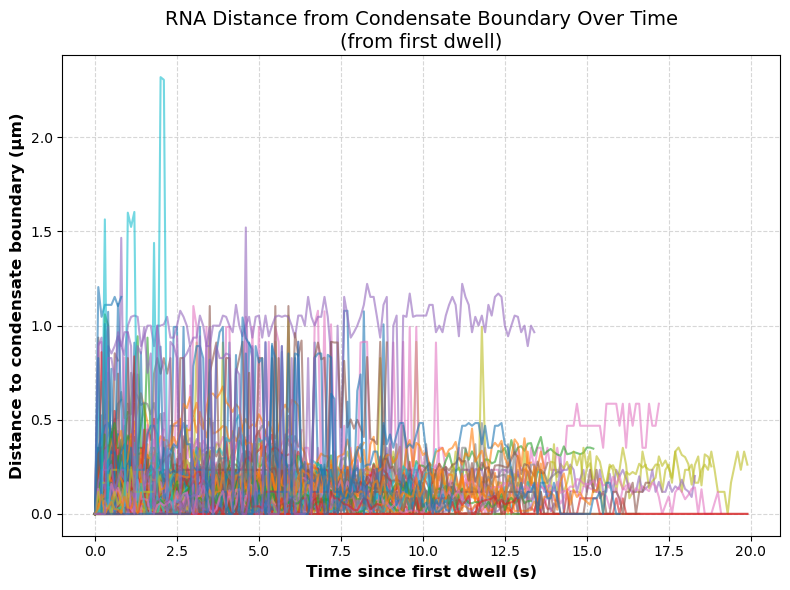

In [20]:
# %% [markdown]
# ## 2. Plot Distance vs. Time from First Dwell Event
# This cell identifies, for each RNA track, the first time it comes within the condensate boundary (distance = 0),
# then plots distance vs. time from that point onward. Saves the figure as `distance_vs_time.png`.

# %%
import matplotlib.pyplot as plt

print("🔄 Generating distance vs. time plots...")

# Load distances if not in memory
try:
    df_distances
except NameError:
    df_distances = pd.read_csv(os.path.join(folder_path, "rna_condensate_distances.csv"))

# Identify first dwell per track per experiment
first_dwell = df_distances[df_distances['distance_um'] == 0] \
    .groupby(['experiment', 'trackID'])['t'] \
    .min() \
    .reset_index() \
    .rename(columns={'t': 't_dwell'})

print(f"  • Found {len(first_dwell)} first-dwell events across all experiments")

# Merge dwell times back into distances
df_plot = df_distances.merge(first_dwell, on=['experiment', 'trackID'], how='left')
# Keep only points at and after first dwell
df_plot = df_plot[df_plot['t'] >= df_plot['t_dwell']]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
for exp in df_plot['experiment'].unique():
    subset = df_plot[df_plot['experiment'] == exp]
    for track in subset['trackID'].unique():
        track_data = subset[subset['trackID'] == track]
        ax.plot(track_data['t'] - track_data['t_dwell'], 
                track_data['distance_um'],
                alpha=0.6,
                label=f"{exp}-T{int(track)}")

ax.set_xlabel("Time since first dwell (s)", fontsize=12, fontweight='bold')
ax.set_ylabel("Distance to condensate boundary (μm)", fontsize=12, fontweight='bold')
ax.set_title("RNA Distance from Condensate Boundary Over Time\n(from first dwell)", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)

# Only show legend if manageable number of tracks
max_legend_entries = 20
handles, labels = ax.get_legend_handles_labels()
if len(labels) <= max_legend_entries:
    ax.legend(fontsize=8, ncol=2, loc='upper right')
else:
    print(f"  ⚠️ Too many tracks ({len(labels)}) for legend; skipping legend display")

plt.tight_layout()
output_png = os.path.join(folder_path, "distance_vs_time.png")
fig.savefig(output_png, dpi=300)
print(f"✅ Saved plot to: {output_png}")
plt.show()


🔄 Generating distance vs. time plots for each experiment...
  • Found 365 first-dwell events across all experiments
  • Creating 26 separate plots...
    → Processing experiment: 20220508-FLmRNA_2x_FOV-17
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-17.png


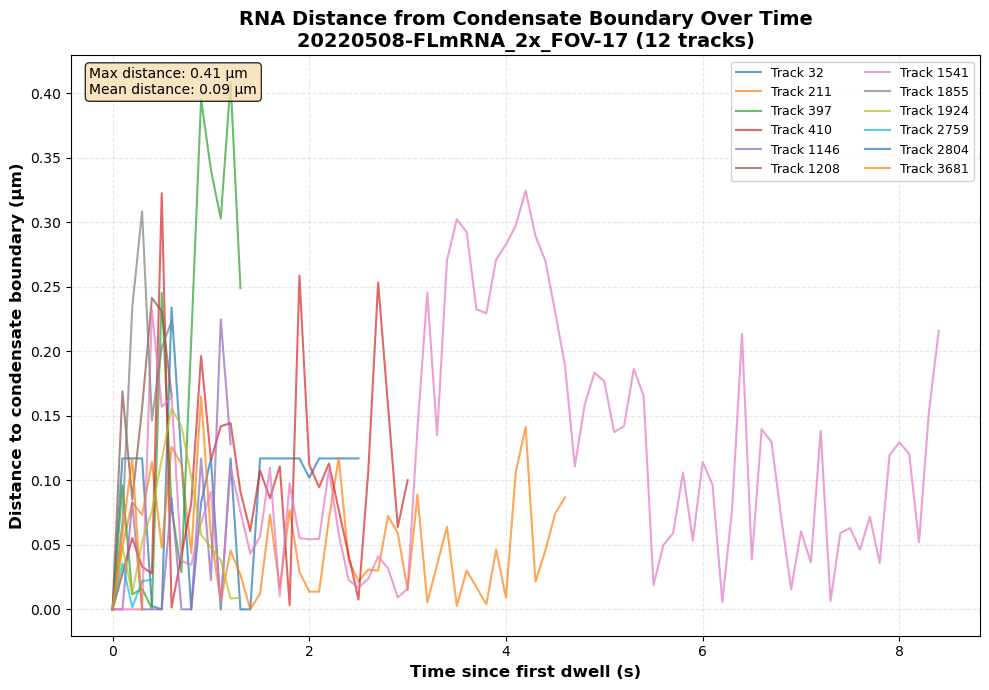

    → Processing experiment: 20220508-FLmRNA_2x_FOV-5
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-5.png


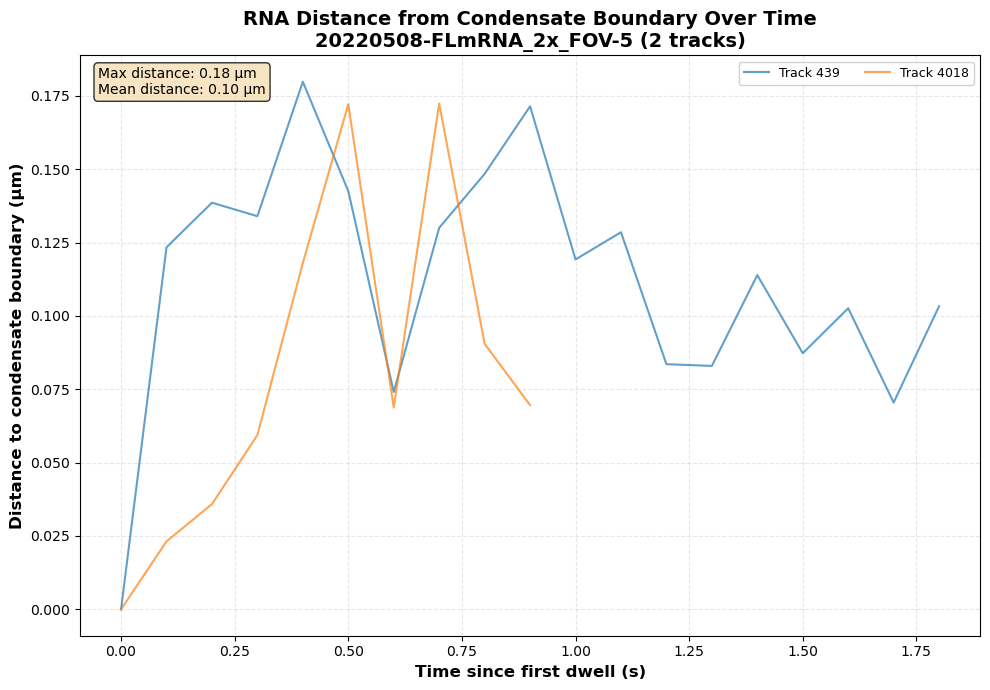

    → Processing experiment: 20220508-FLmRNA_2x_FOV-25
      ⚠️ Too many tracks (24) for legend in 20220508-FLmRNA_2x_FOV-25
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-25.png


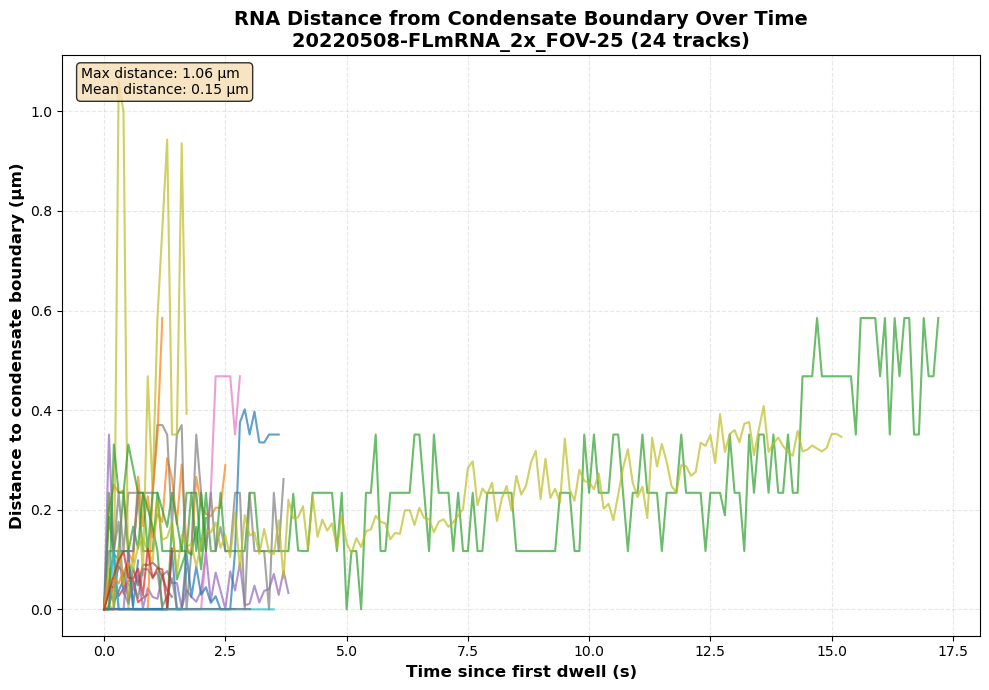

    → Processing experiment: 20220508-FLmRNA_2x_FOV-15
      ⚠️ Too many tracks (20) for legend in 20220508-FLmRNA_2x_FOV-15
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-15.png


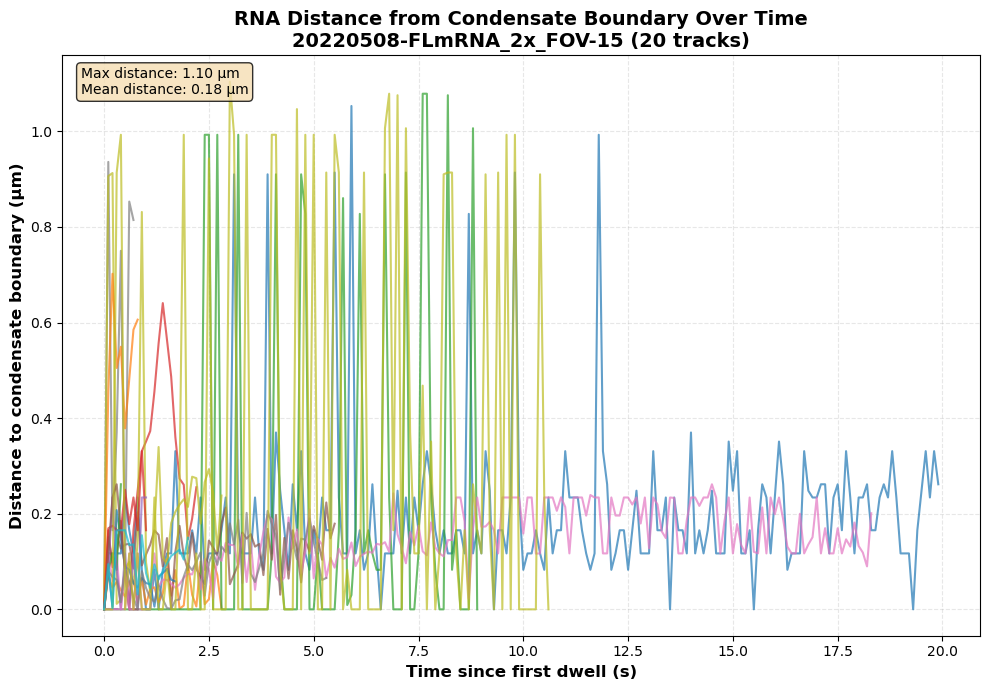

    → Processing experiment: 20220508-FLmRNA_2x_FOV-7
      ⚠️ Too many tracks (20) for legend in 20220508-FLmRNA_2x_FOV-7
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-7.png


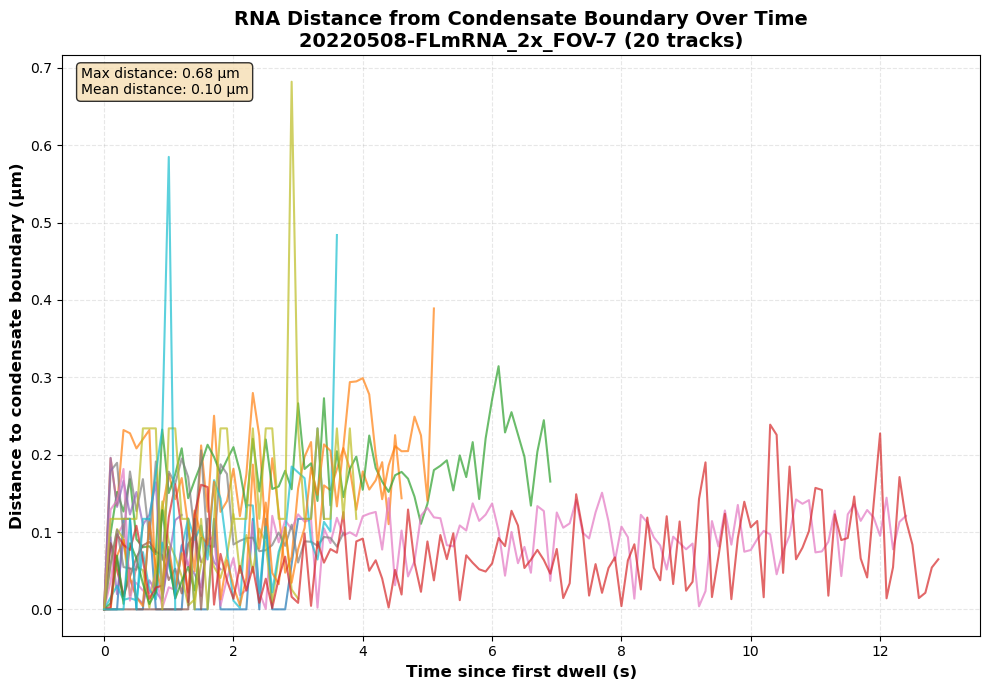

    → Processing experiment: 20220508-FLmRNA_2x_FOV-1
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-1.png


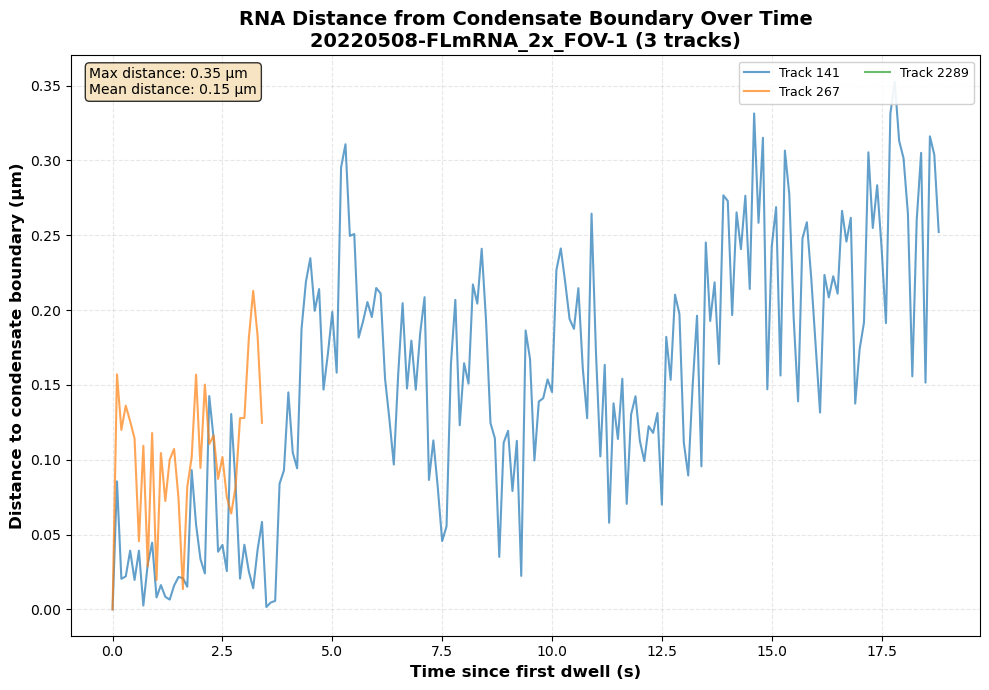

    → Processing experiment: 20220508-FLmRNA_2x_FOV-21
      ⚠️ Too many tracks (19) for legend in 20220508-FLmRNA_2x_FOV-21
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-21.png


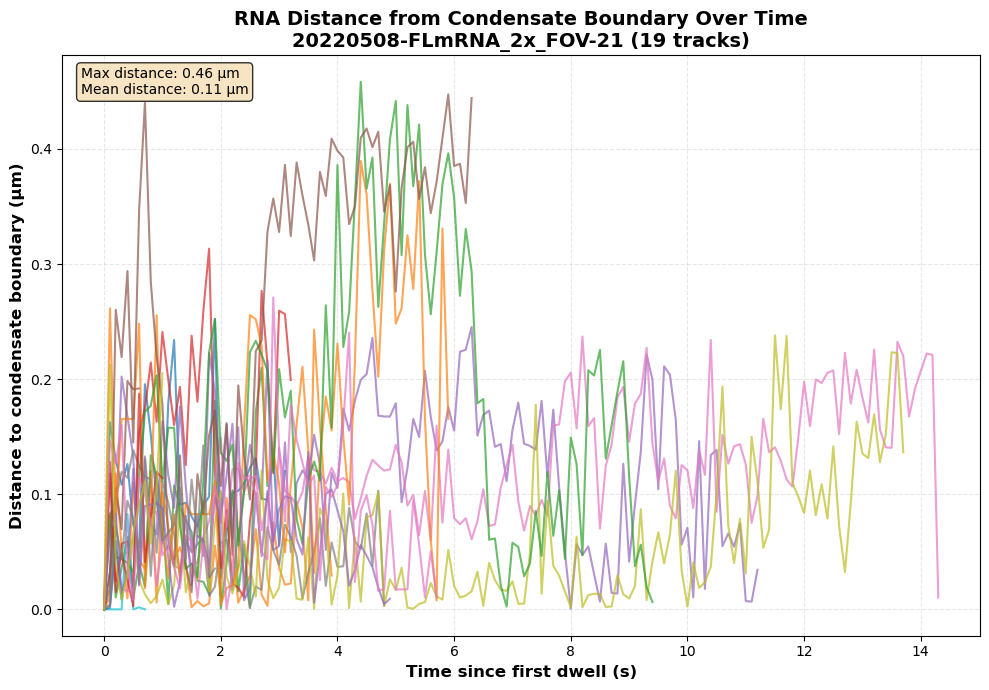

    → Processing experiment: 20220508-FLmRNA_2x_FOV-9
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-9.png


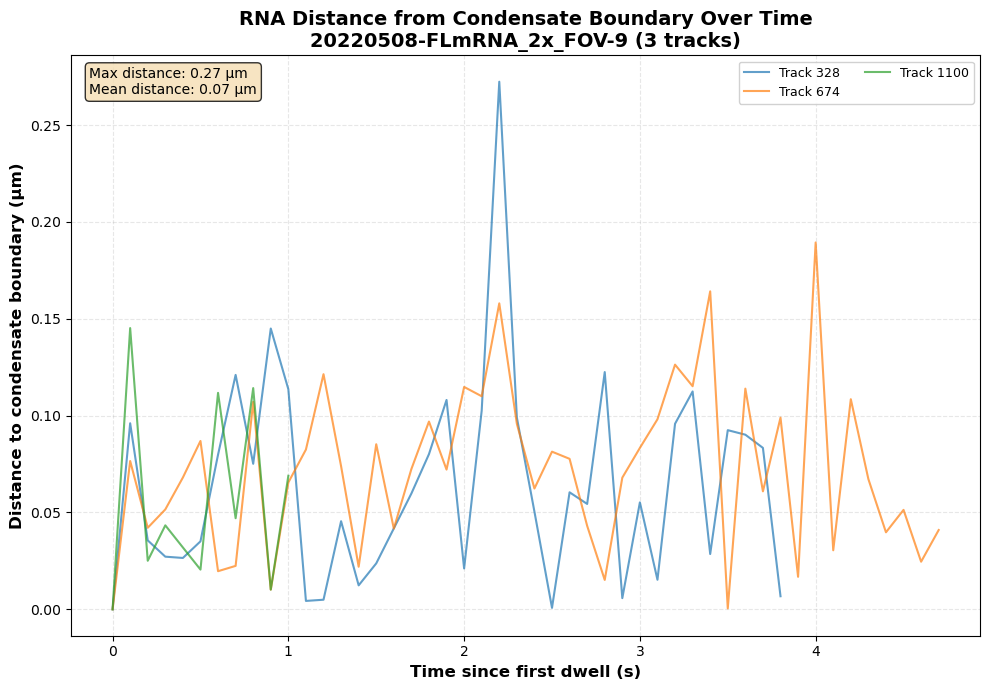

    → Processing experiment: 20220508-FLmRNA_2x_FOV-13
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-13.png


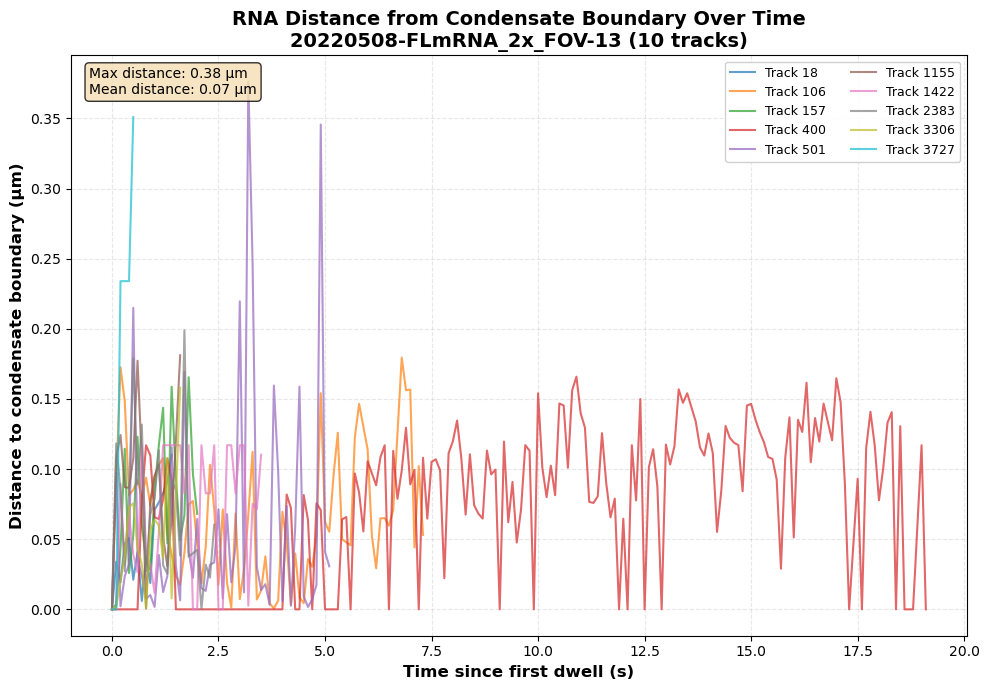

    → Processing experiment: 20220508-FLmRNA_2x_FOV-19
      ⚠️ Too many tracks (19) for legend in 20220508-FLmRNA_2x_FOV-19
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-19.png


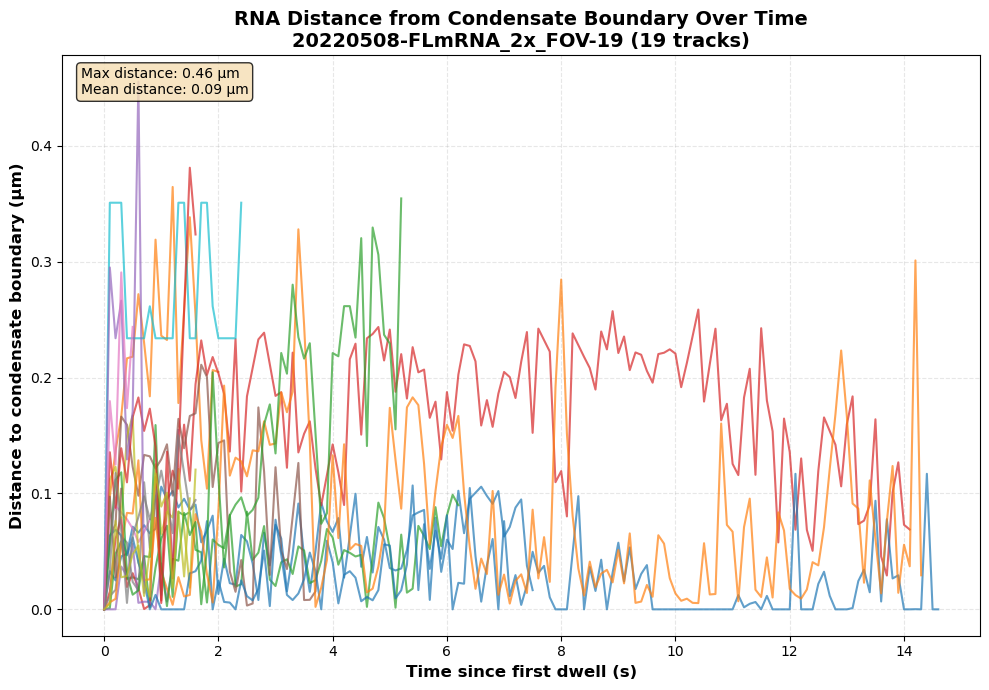

    → Processing experiment: 20220508-FLmRNA_2x_FOV
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV.png


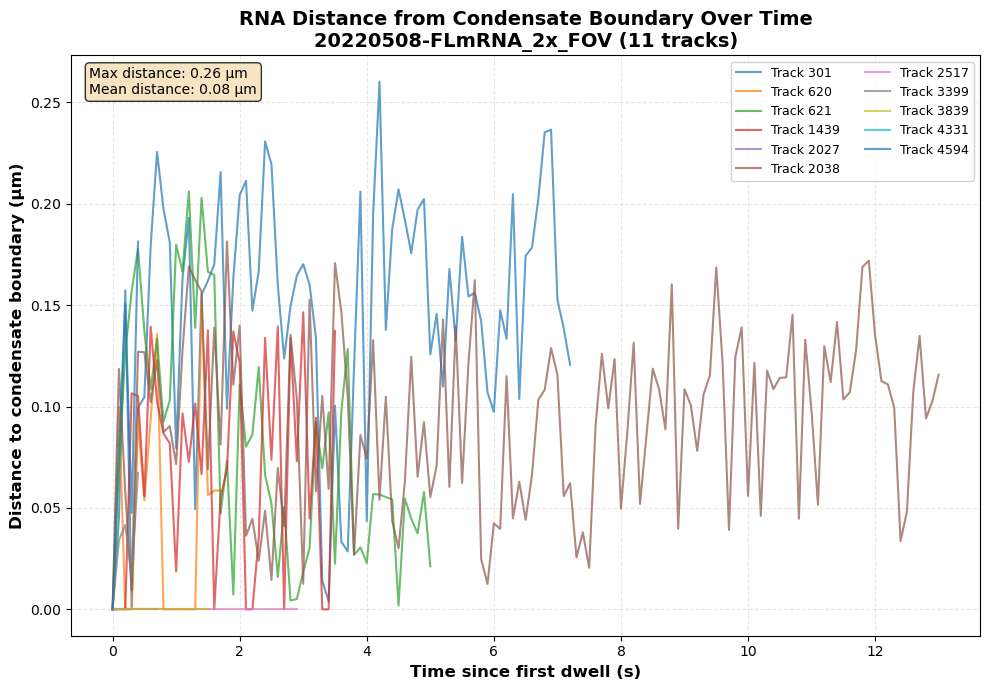

    → Processing experiment: 20220508-FLmRNA_2x_FOV-3
      ⚠️ Too many tracks (30) for legend in 20220508-FLmRNA_2x_FOV-3
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-3.png


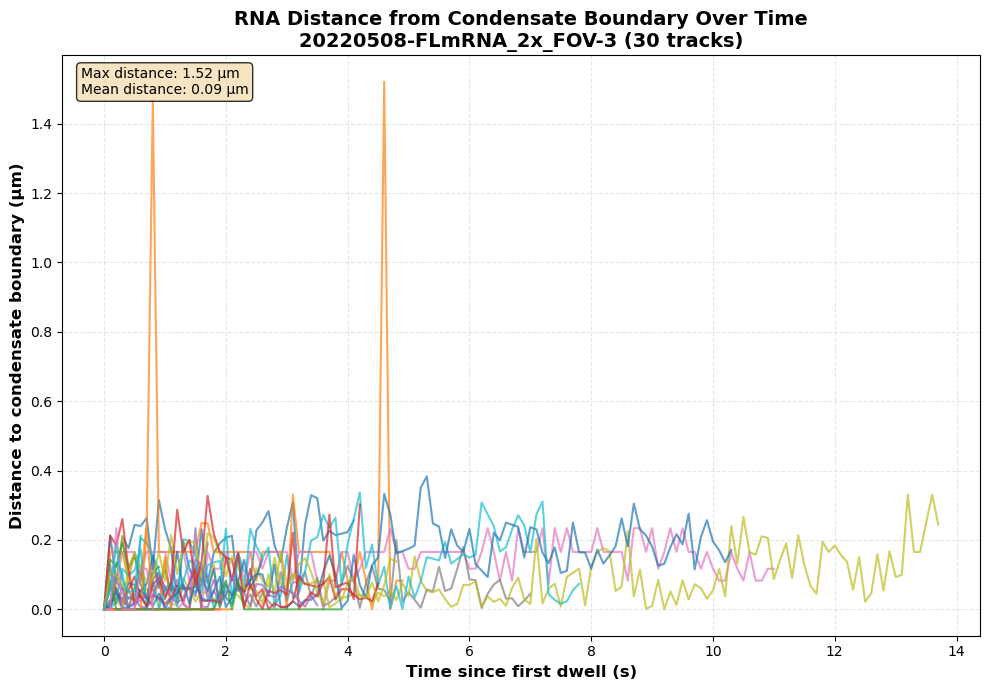

    → Processing experiment: 20220508-FLmRNA_2x_FOV-23
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-23.png


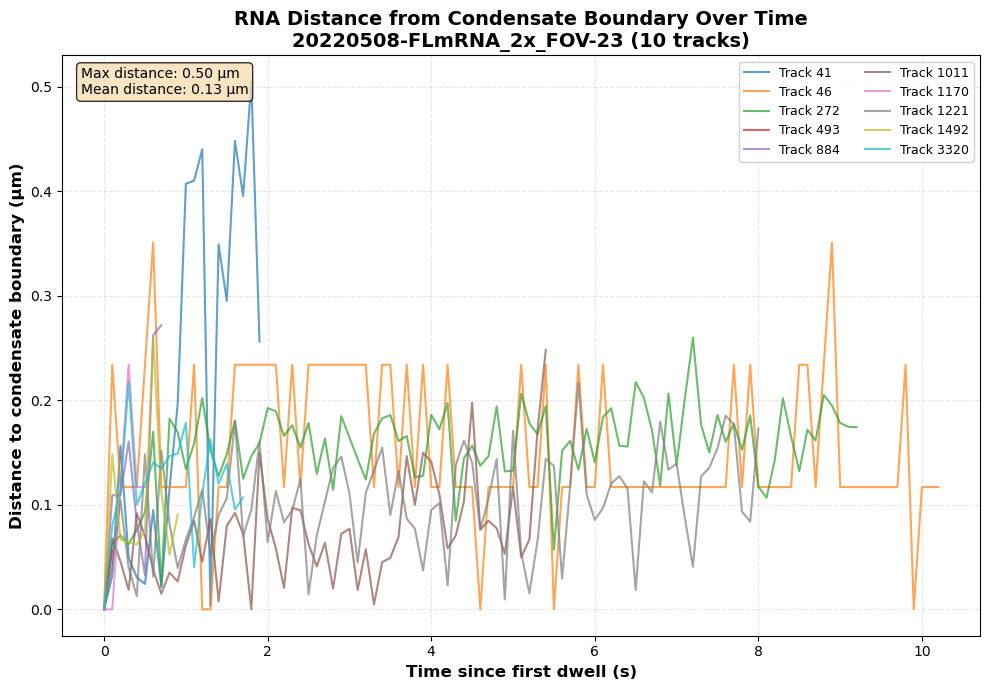

    → Processing experiment: 20220508-FLmRNA_2x_FOV-11
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-11.png


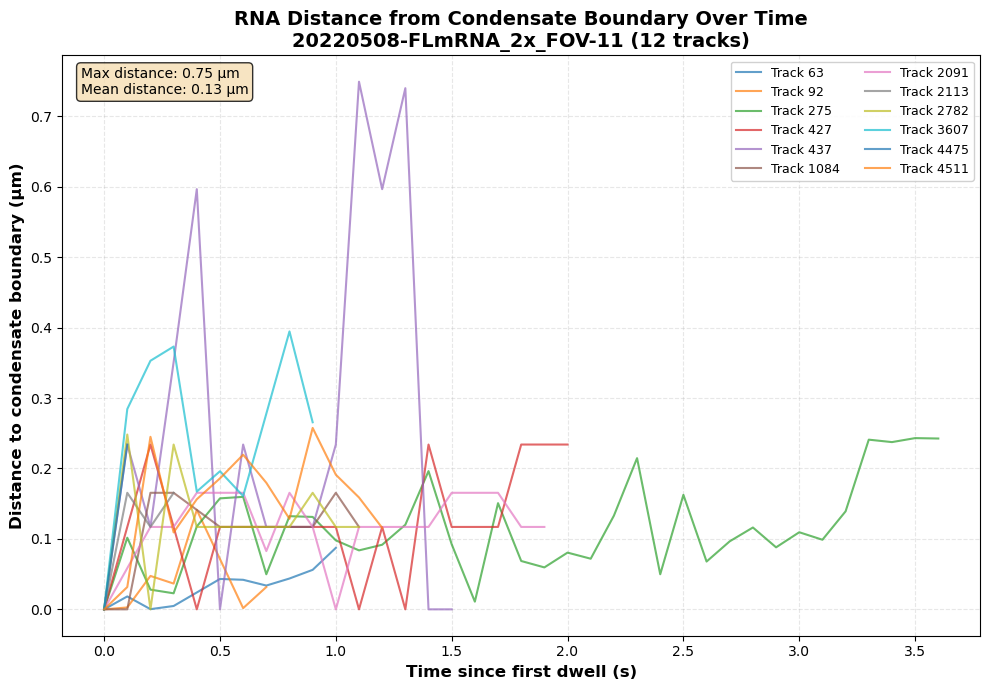

    → Processing experiment: 20220508-FLmRNA_2x_FOV-24
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-24.png


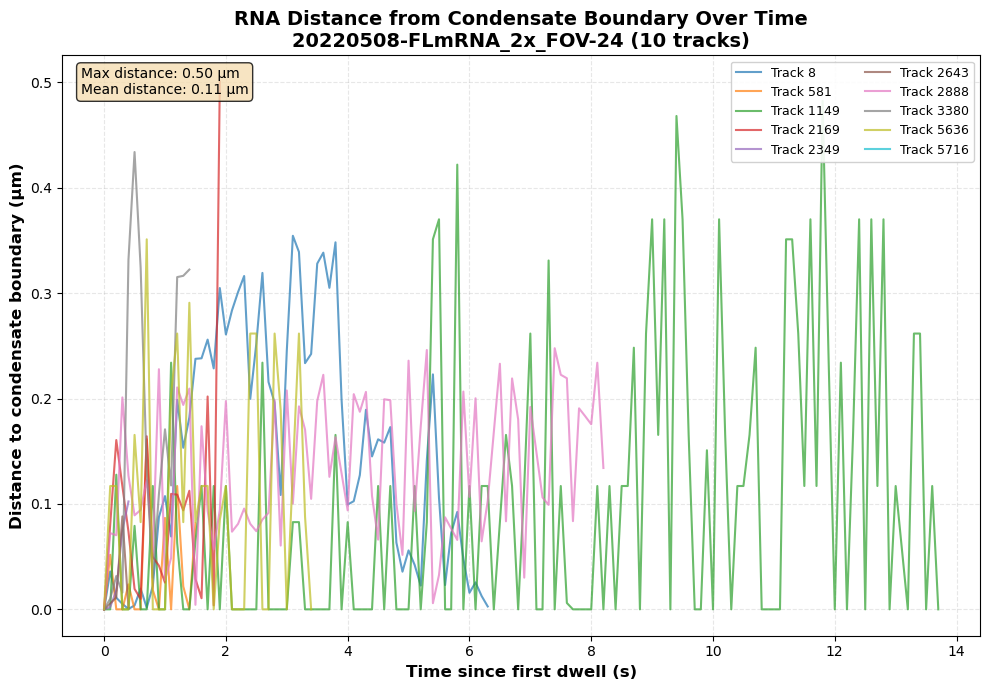

    → Processing experiment: 20220508-FLmRNA_2x_FOV-4
      ⚠️ Too many tracks (34) for legend in 20220508-FLmRNA_2x_FOV-4
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-4.png


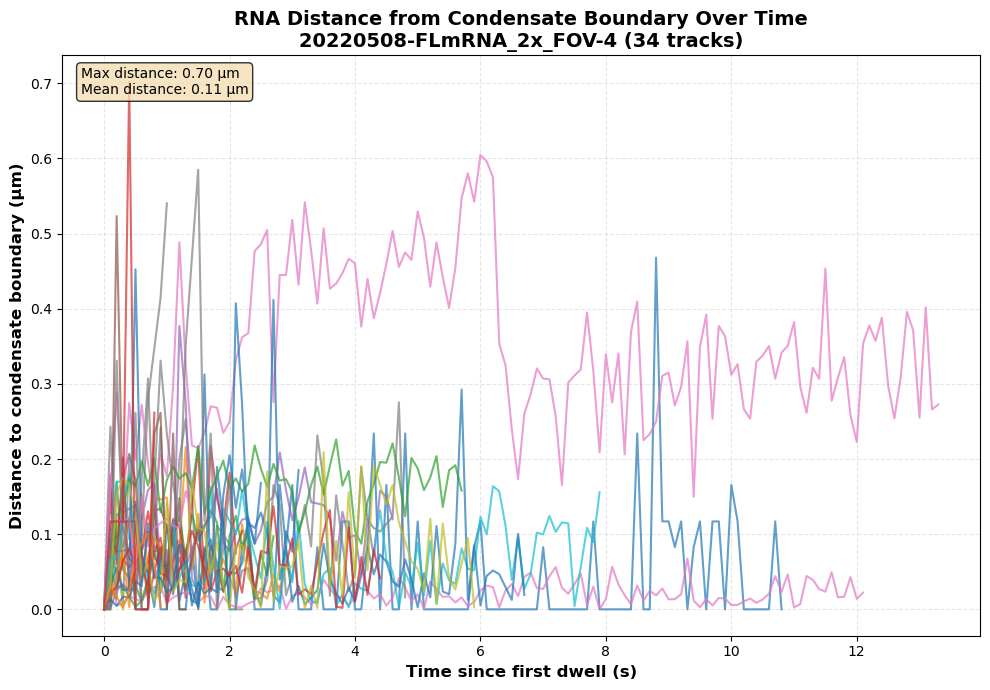

    → Processing experiment: 20220508-FLmRNA_2x_FOV-16
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-16.png


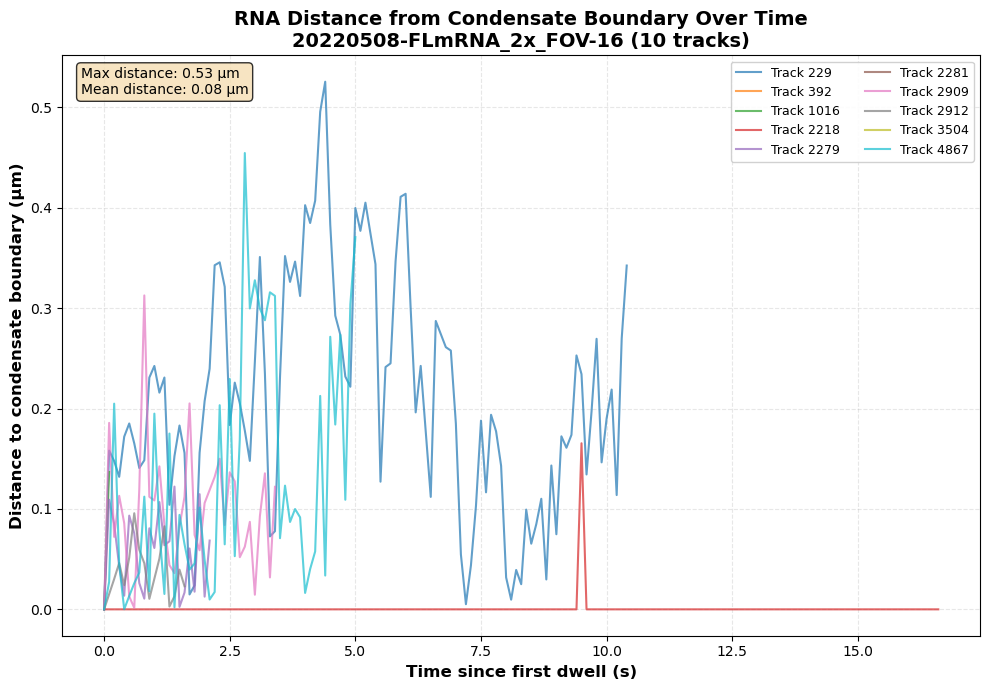

    → Processing experiment: 20220508-FLmRNA_2x_FOV-6
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-6.png


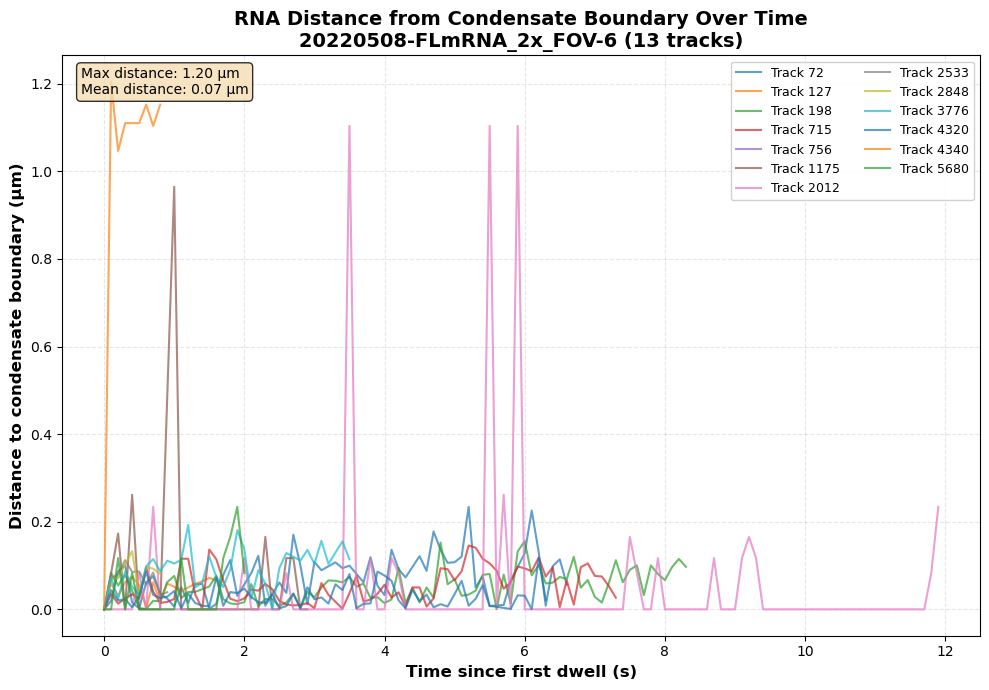

    → Processing experiment: 20220508-FLmRNA_2x_FOV-14
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-14.png


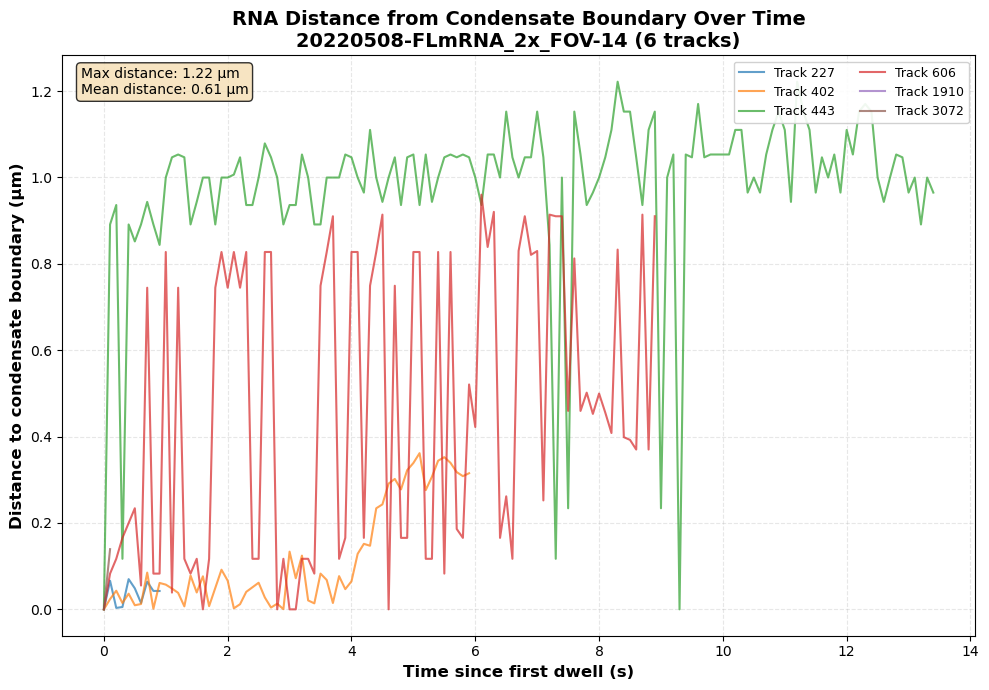

    → Processing experiment: 20220508-FLmRNA_2x_FOV-8
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-8.png


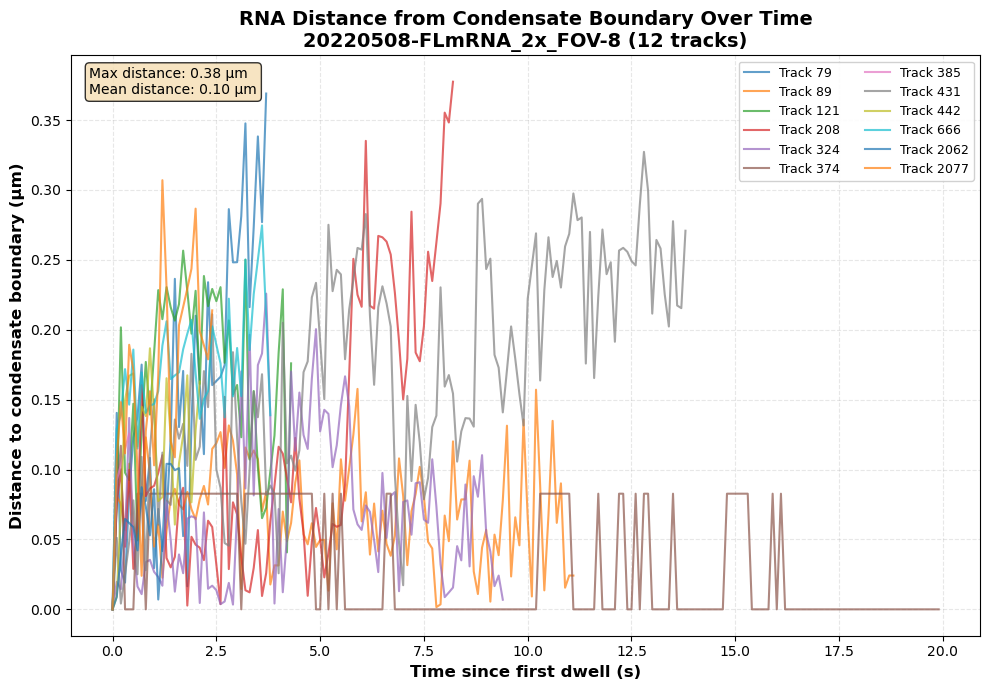

    → Processing experiment: 20220508-FLmRNA_2x_FOV-12
      ⚠️ Too many tracks (24) for legend in 20220508-FLmRNA_2x_FOV-12
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-12.png


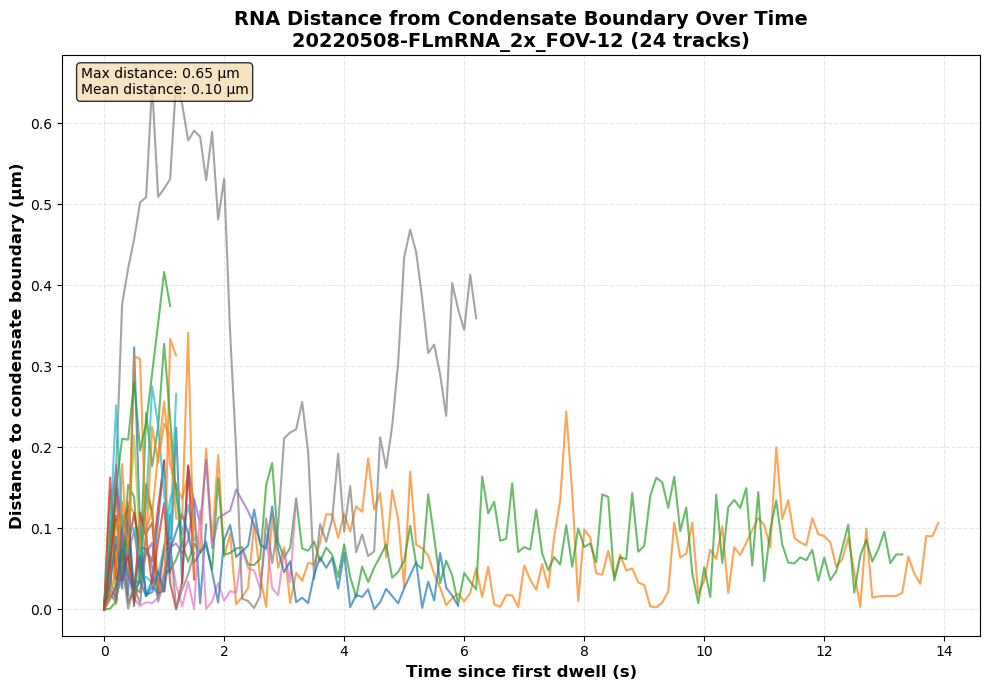

    → Processing experiment: 20220508-FLmRNA_2x_FOV-20
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-20.png


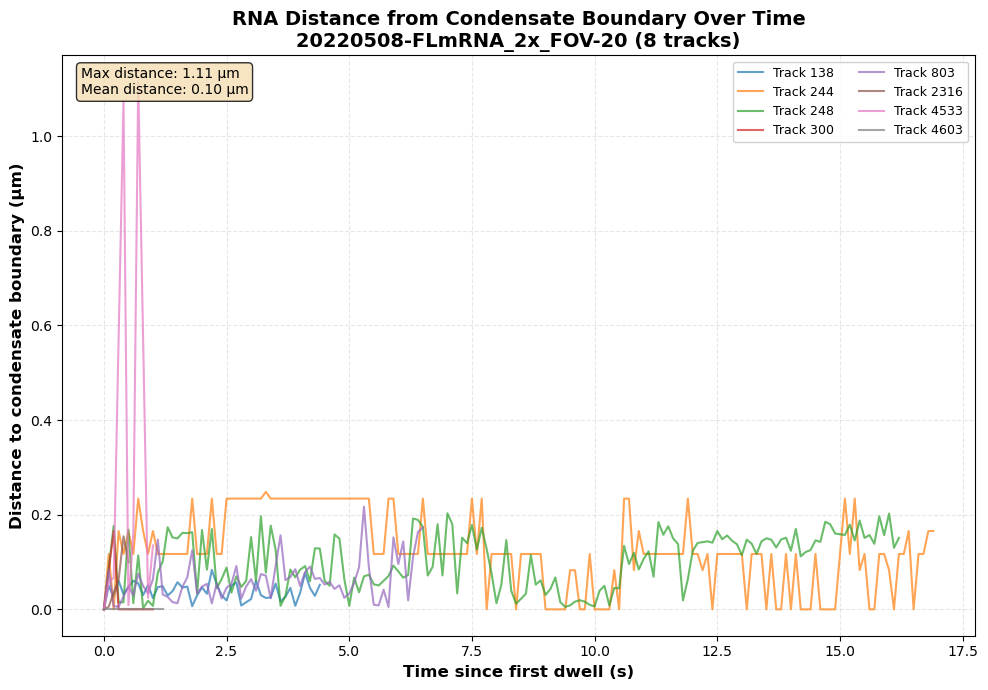

    → Processing experiment: 20220508-FLmRNA_2x_FOV-10
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-10.png


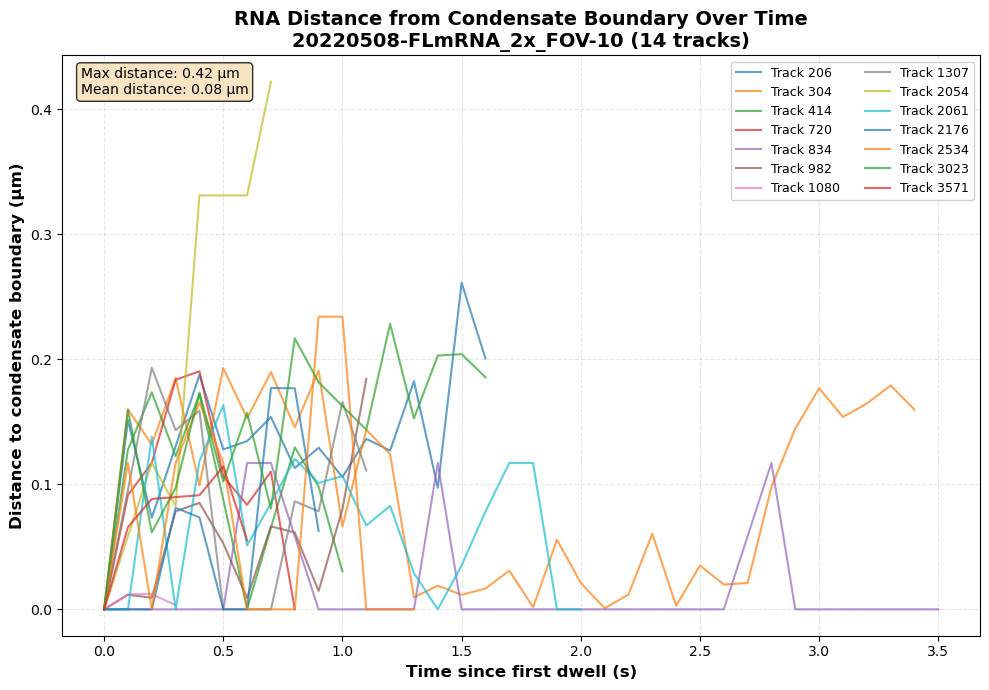

    → Processing experiment: 20220508-FLmRNA_2x_FOV-18
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-18.png


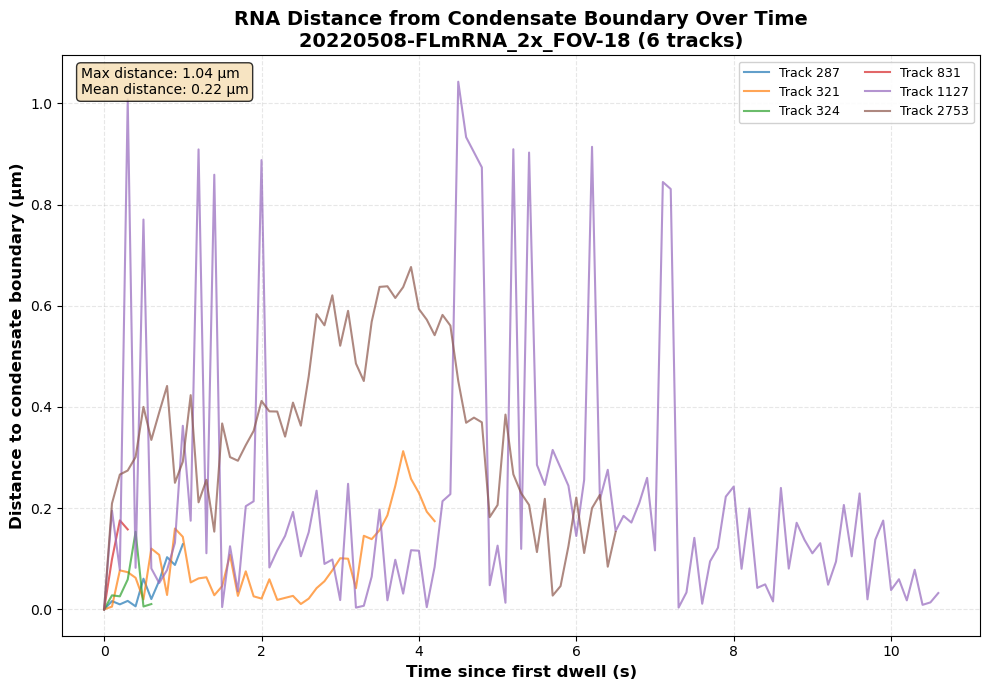

    → Processing experiment: 20220508-FLmRNA_2x_FOV-22
      ⚠️ Too many tracks (27) for legend in 20220508-FLmRNA_2x_FOV-22
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-22.png


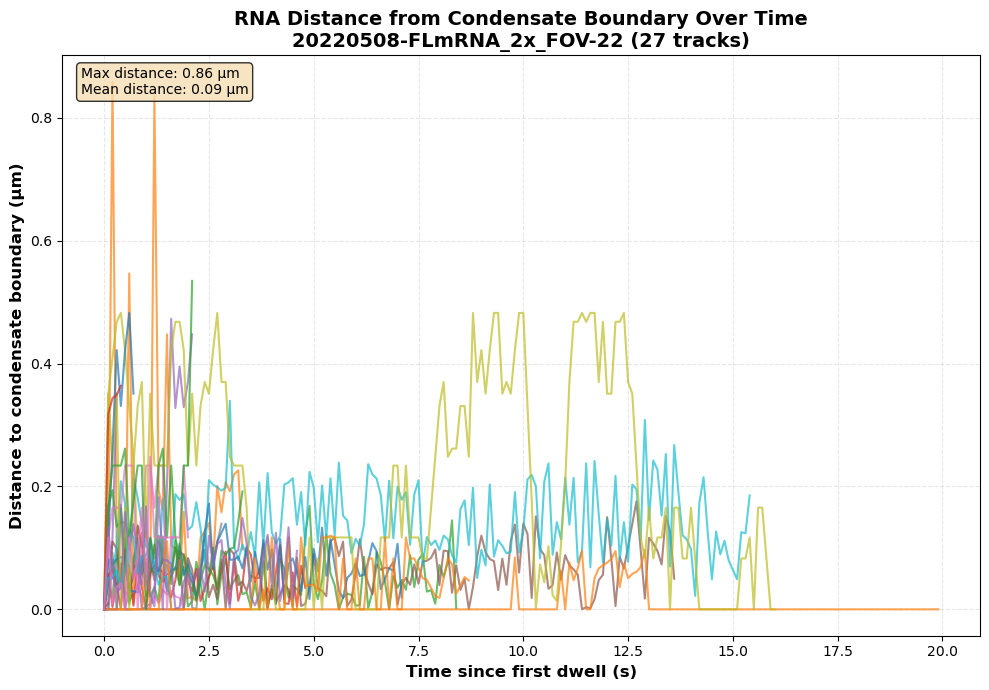

    → Processing experiment: 20220508-FLmRNA_2x_FOV-2
      ✅ Saved: distance_vs_time_20220508-FLmRNA_2x_FOV-2.png


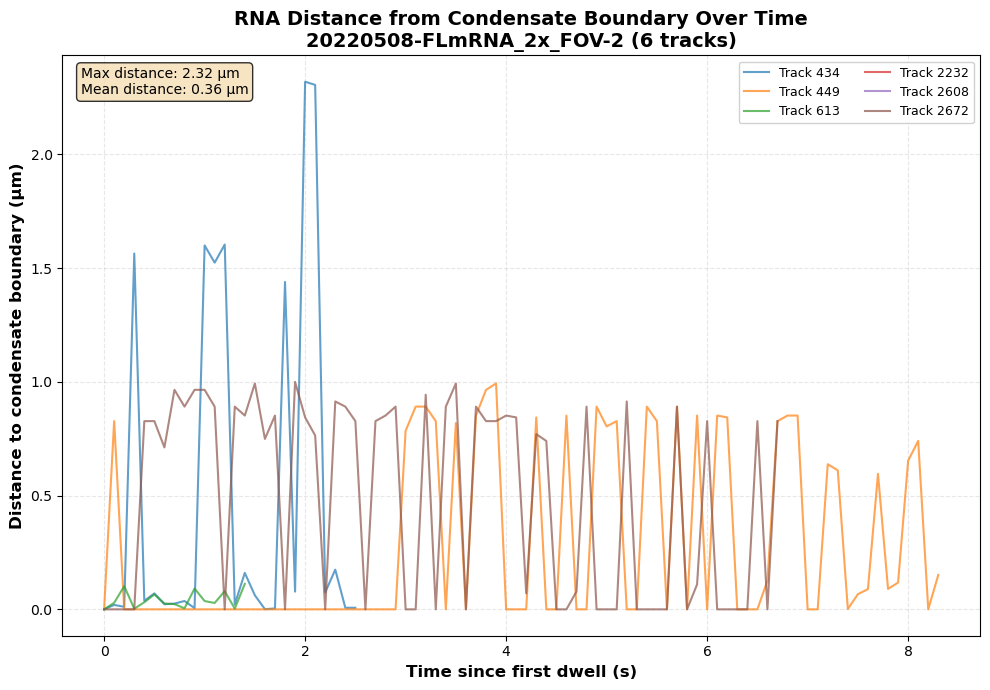

🎉 Created 26 individual distance vs. time plots!


In [21]:
# %% [markdown]
# ## 2. Plot Distance vs. Time from First Dwell Event (Separate Plot per Experiment)
# This cell identifies, for each RNA track, the first time it comes within the condensate boundary (distance = 0),
# then plots distance vs. time from that point onward. Creates a separate plot for each experiment.
# Saves figures as `distance_vs_time_[experiment_name].png`.

# %%
import matplotlib.pyplot as plt

print("🔄 Generating distance vs. time plots for each experiment...")

# Load distances if not in memory
try:
    df_distances
except NameError:
    df_distances = pd.read_csv(os.path.join(folder_path, "rna_condensate_distances.csv"))

# Identify first dwell per track per experiment
first_dwell = df_distances[df_distances['distance_um'] == 0] \
    .groupby(['experiment', 'trackID'])['t'] \
    .min() \
    .reset_index() \
    .rename(columns={'t': 't_dwell'})

print(f"  • Found {len(first_dwell)} first-dwell events across all experiments")

# Merge dwell times back into distances
df_plot = df_distances.merge(first_dwell, on=['experiment', 'trackID'], how='left')
# Keep only points at and after first dwell
df_plot = df_plot[df_plot['t'] >= df_plot['t_dwell']]

# Create separate plot for each experiment
experiments = df_plot['experiment'].unique()
print(f"  • Creating {len(experiments)} separate plots...")

for exp in experiments:
    print(f"    → Processing experiment: {exp}")
    
    # Filter data for this experiment
    exp_data = df_plot[df_plot['experiment'] == exp]
    
    if exp_data.empty:
        print(f"      ⚠️ No dwell data found for {exp}, skipping...")
        continue
    
    # Create figure for this experiment
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot each track in this experiment
    track_count = 0
    for track in exp_data['trackID'].unique():
        track_data = exp_data[exp_data['trackID'] == track]
        
        # Use different colors for better visibility
        ax.plot(track_data['t'] - track_data['t_dwell'], 
                track_data['distance_um'],
                alpha=0.7,
                linewidth=1.5,
                label=f"Track {int(track)}")
        track_count += 1
    
    ax.set_xlabel("Time since first dwell (s)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Distance to condensate boundary (μm)", fontsize=12, fontweight='bold')
    ax.set_title(f"RNA Distance from Condensate Boundary Over Time\n{exp} ({track_count} tracks)", 
                fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add legend with reasonable limit
    max_legend_entries = 15
    if track_count <= max_legend_entries:
        ax.legend(fontsize=9, ncol=2, loc='upper right', framealpha=0.9)
    else:
        print(f"      ⚠️ Too many tracks ({track_count}) for legend in {exp}")
    
    # Add summary statistics as text box
    max_dist = exp_data['distance_um'].max()
    mean_dist = exp_data['distance_um'].mean()
    textstr = f'Max distance: {max_dist:.2f} μm\nMean distance: {mean_dist:.2f} μm'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save with experiment-specific filename
    safe_exp_name = exp.replace(" ", "_").replace("/", "_").replace("\\", "_")
    output_png = os.path.join(folder_path, f"distance_vs_time_{safe_exp_name}.png")
    fig.savefig(output_png, dpi=300, bbox_inches='tight')
    print(f"      ✅ Saved: distance_vs_time_{safe_exp_name}.png")
    
    plt.show()
    plt.close()  # Close to free memory

print(f"🎉 Created {len(experiments)} individual distance vs. time plots!")
